# INIT

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Librerias

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# MODULES PATH
import sys
sys.path.append('/content/drive/MyDrive/TFM_Retail_Repo/03_Clustering')

## Importacion datos

In [52]:
# Diccionario colecciones
db_collections = [
    'calendar',
    'items',
    'prices',
    'tiendas',
    'departments',
    'sales_main',
    'weekly_sales',
    'year_sales',
    'day_sales'
    ]

### Mongo DB

In [53]:
'''
from modules.mongo_local_module import connect_to_db, get_collection_as_dataframe

db_name = 'ds_market'         # Nombre de la base de datos

# Conectar a la base de datos
db = connect_to_db(db_name, local=True)

# Obtener colecciones
df_cal = get_collection_as_dataframe(db, 'calendar').drop(columns='_id')
# Se añadieron columnas week y month a calendar para hacer cruces de datos mas faciles

df_cal = df_cal.fillna('None') # event tiene NaN

df_shops = get_collection_as_dataframe(db, 'tiendas').drop(columns='_id')
df_items = get_collection_as_dataframe(db, 'items').drop(columns='_id')

df_ws = get_collection_as_dataframe(db, 'weekly_sales').drop(columns='_id')

# Añadimos eventos para no perder esa información
# Crear un diccionario desde df_cal
event_dict = df_cal.set_index('week')['event'].to_dict()

# Añadir la columna 'event' a df_ws usando el método 'map'
df_ws['event'] = df_ws['week'].map(event_dict)
'''

"\nfrom modules.mongo_local_module import connect_to_db, get_collection_as_dataframe\n\ndb_name = 'ds_market'         # Nombre de la base de datos\n\n# Conectar a la base de datos\ndb = connect_to_db(db_name, local=True)\n\n# Obtener colecciones\ndf_cal = get_collection_as_dataframe(db, 'calendar').drop(columns='_id')\n# Se añadieron columnas week y month a calendar para hacer cruces de datos mas faciles\n\ndf_cal = df_cal.fillna('None') # event tiene NaN\n\ndf_shops = get_collection_as_dataframe(db, 'tiendas').drop(columns='_id')\ndf_items = get_collection_as_dataframe(db, 'items').drop(columns='_id')\n\ndf_ws = get_collection_as_dataframe(db, 'weekly_sales').drop(columns='_id')\n\n# Añadimos eventos para no perder esa información\n# Crear un diccionario desde df_cal\nevent_dict = df_cal.set_index('week')['event'].to_dict()\n\n# Añadir la columna 'event' a df_ws usando el método 'map'\ndf_ws['event'] = df_ws['week'].map(event_dict)\n"

### CSVs

In [54]:
from modules.get_data import get_data

In [55]:
df_cal = get_data('exp_calendar.csv')
df_items = get_data('exp_items.csv')
df_shops = get_data('exp_shops.csv')
df_ws = get_data('exp_weekly_sales.csv')

# Renombrar columnas específicas
df_ws = df_ws.rename(columns={ #ejercicio, semana, unidades, cifra
    'ejercicio': 'year',
    'semana': 'week',
    'unidades': 'units',
    'cifra': 'raw_earn',
    })

In [56]:
display(df_cal.head())
display(df_items.head())
display(df_shops.head())
display(df_ws.head())

,fecha,event
0,2011-02-06,SuperBowl
1,2011-08-01,Ramadan starts
2,2011-11-24,Thanksgiving
3,2012-01-01,NewYear
4,2012-02-05,SuperBowl


,item,category,department
0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1
1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1
2,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1
3,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1
4,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1


,store_code,region,store
0,NYC_1,New York,Greenwich_Village
1,NYC_2,New York,Harlem
2,NYC_3,New York,Tribeca
3,NYC_4,New York,Brooklyn
4,BOS_1,Boston,South_End


,item,store_code,year,week,units,sell_price,raw_earn
0,ACCESORIES_1_004,BOS_1,2011,4,3.0,5.77,17.32
1,ACCESORIES_1_004,BOS_2,2011,4,8.0,5.77,46.18
2,ACCESORIES_1_004,NYC_2,2011,4,9.0,5.77,51.95
3,ACCESORIES_1_004,NYC_4,2011,4,2.0,5.77,11.54
4,ACCESORIES_1_004,PHI_1,2011,4,3.0,5.77,17.32


# **CREACION CARACTERISTICAS**
___
___  
  
Creamos las caracteristicas generales y luego filtraremos para cada supuesto.

In [ ]:
# !pip install featuretools # install the missing module

In [58]:
from modules import feature_creation_module as fcm

Resumen de las **Primitivas de Agregación** y **Transformación**:

**Primitivas de Agregación:**

1\. **`sum`**:

   - **Por qué la usamos**: Nos permite calcular el total de unidades vendidas y los ingresos (`raw_earn`) generados por cada producto.

   - **Qué esperamos obtener**: Queremos conocer cuáles productos generan mayores ingresos o tienen mayores volúmenes de venta en total, lo cual es un indicador de rendimiento absoluto.

2\. **`mean`**:

   - **Por qué la usamos**: El promedio de ventas (`units`) y el precio de venta (`sell_price`) por semana nos ayuda a ver qué tan consistente es el rendimiento de un producto a lo largo del tiempo.

   - **Qué esperamos obtener**: Identificar productos con un rendimiento constante o con precios estables, lo cual puede ser útil para determinar qué productos son menos volátiles en términos de ventas o precio.

3\. **`std`**:

   - **Por qué la usamos**: La desviación estándar mide la variabilidad en ventas y en ingresos. Es útil para entender la estabilidad o fluctuación de los productos.

   - **Qué esperamos obtener**: Productos con alta desviación estándar tienen ventas más impredecibles, mientras que aquellos con baja desviación estándar son más consistentes. Esto ayuda a identificar productos estables frente a aquellos que experimentan picos o caídas drásticas.

4\. **`count`**:

   - **Por qué la usamos**: Nos ayuda a saber en cuántas tiendas se vendió cada producto.

   - **Qué esperamos obtener**: Determina la penetración del producto en el mercado. Productos que se venden en más tiendas podrían ser más populares o estar más ampliamente disponibles.

5\. **`max`**:

   - **Por qué la usamos**: Queremos conocer el valor máximo de ventas (`units`) o ingresos (`raw_earn`) de un producto en una semana.

   - **Qué esperamos obtener**: Identificar productos que hayan tenido semanas excepcionales de ventas o ingresos, lo que puede indicar eventos o promociones que impulsaron el rendimiento.

---

**Primitivas de Transformación:**

1\. **`divide_numeric`**:

   - **Por qué la usamos**: Calcula relaciones como `units/sell_price`, lo que nos permite obtener el ratio de unidades vendidas por cada unidad de precio.

   - **Qué esperamos obtener**: Nos da una idea de cómo varía la relación entre el precio y las ventas. Por ejemplo, productos que venden muchas unidades a precios más bajos podrían comportarse de manera diferente a aquellos que venden menos unidades a precios altos.

2\. **`percentile`**:

   - **Por qué la usamos**: Nos permite calcular el percentil de un valor en una distribución (por ejemplo, cómo se comparan las ventas de un producto con el resto).

   - **Qué esperamos obtener**: Clasificar productos según su rendimiento en comparación con los demás. Esto nos ayuda a identificar cuáles están en los niveles más altos o bajos de rendimiento relativo.

---

¿Qué esperamos obtener con estas características?

1\. **Identificación de patrones de ventas**:

   - Queremos descubrir qué productos se venden de forma constante (baja variabilidad) frente a aquellos que son más volátiles (alta desviación estándar en ventas o ingresos).

2\. **Estudio del precio frente a las ventas**:

   - Al calcular ratios como `units/sell_price`, buscamos entender si el precio influye en el volumen de ventas. Productos con un bajo precio podrían compensar con altos volúmenes de venta y viceversa.

En resumen, estas características nos ayudarán a realizar un **clustering más efectivo**, diferenciando productos con base en su rendimiento en ventas, su consistencia, su presencia en distintas tiendas y cómo reaccionan a factores como el precio o el tiempo.

In [59]:
# # Creacion caracteristicas para productos basadas en ventas/performance
# fc_config = {
#     'target_df': 'items',  # Objetivo: productos
#     'agg_primitives': [
#         'sum',      # Total de ventas, ingresos
#         'mean',     # Promedio de ventas, precio, ingresos
#         'std',      # Variabilidad en ventas e ingresos
#         'count'     # Total de tiendas donde se vendió
#     ],
#     'trans_primitives': [],
#     'max_depth': 2
# }

# V2
fc_config = {
    'target_df': 'items',  # Nombre del DataFrame objetivo
    'agg_primitives': [
        'min',               # Mínimo
        'max',               # Máximo
        'mean',              # Promedio
        'std',               # Desviación estándar
        'sum',               # Suma
        'count'              # Totales
    ],
    'trans_primitives': [
        # 'divide_numeric',    # División entre características numéricas -> GENERA MUCHAS!!!
        'percentile'       # Porcentaje de ventas respecto a la tienda de mayor rendimiento
    ],
    'max_depth': 2         # Profundidad máxima de la generación de características
}


feature_matrix, feature_defs = fcm.create_features(df_items, df_shops, df_ws, fc_config)

/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. 

In [60]:
print(f'FeatMatrix shape : {feature_matrix.shape}')

print(f'Feat Defs length: {len(feature_defs)}')

FeatMatrix shape : (3049, 79)
Feat Defs length: 79


### Feat Descriptions

In [61]:
# Revision definiciones caracteristicas creadas
features_descriptions = fcm.get_features_descriptions(feature_defs)

display(type(features_descriptions))

display(features_descriptions)

list

['<Feature: category>: The "category".',
 '<Feature: department>: The "department".',
 '<Feature: COUNT(sales)>: The number of all instances of "sales" for each "item" in "items".',
 '<Feature: MAX(sales.raw_earn)>: The maximum of the "raw_earn" of all instances of "sales" for each "item" in "items".',
 '<Feature: MAX(sales.sell_price)>: The maximum of the "sell_price" of all instances of "sales" for each "item" in "items".',
 '<Feature: MAX(sales.units)>: The maximum of the "units" of all instances of "sales" for each "item" in "items".',
 '<Feature: MAX(sales.week)>: The maximum of the "week" of all instances of "sales" for each "item" in "items".',
 '<Feature: MAX(sales.year)>: The maximum of the "year" of all instances of "sales" for each "item" in "items".',
 '<Feature: MEAN(sales.raw_earn)>: The average of the "raw_earn" of all instances of "sales" for each "item" in "items".',
 '<Feature: MEAN(sales.sell_price)>: The average of the "sell_price" of all instances of "sales" for ea

# **PRODUCTOS: PERFORMANCE**
___
___

## Seleccion caracteristicas

In [62]:
# Seleccionar y renombrar características relevantes para el clustering de productos ventas/performance
'''
selected_features = {
    'COUNT(sales)': 'num_sales',
    'SUM(sales.units)': 'total_units_sold',
    'SUM(sales.raw_earn)': 'total_revenue',
    'MEAN(sales.sell_price)': 'avg_sell_price',
    'STD(sales.sell_price)': 'std_sell_price',
    'STD(sales.units)': 'std_units_sold',
    'MEAN(sales.units)': 'avg_units_per_week',
    'MEAN(sales.week)': 'avg_week',
    'STD(sales.week)': 'std_week',
    'MEAN(sales.year)': 'avg_year'
}
'''

# V2
'''
sales_features = {
    'COUNT(sales)': 'num_sales',                                  # Número total de ventas
    'SUM(sales.raw_earn)': 'total_revenue',                       # Suma total de las ganancias brutas
    'MEAN(sales.raw_earn)': 'avg_revenue',                        # Ganancia bruta promedio
    'MAX(sales.raw_earn)': 'max_revenue',                         # Máxima ganancia bruta
    'MIN(sales.raw_earn)': 'min_revenue',                         # Mínima ganancia bruta
    'STD(sales.raw_earn)': 'std_revenue',                         # Desviación estándar de las ganancias brutas
    'MEAN(sales.units)': 'avg_units_sold',                        # Promedio de unidades vendidas
    'MAX(sales.units)': 'max_units_sold',                         # Máximo número de unidades vendidas
    'SUM(sales.units)': 'total_units_sold',                       # Total de unidades vendidas
    'PERCENTILE(MAX(sales.raw_earn))': 'percentile_max_revenue',  # Percentil del máximo de ganancias brutas
    'PERCENTILE(MEAN(sales.raw_earn))': 'percentile_avg_revenue', # Percentil del promedio de ganancias brutas
    'PERCENTILE(STD(sales.raw_earn))': 'percentile_std_revenue',  # Percentil de la desviación estándar de las ganancias brutas
    'PERCENTILE(SUM(sales.raw_earn))': 'percentile_total_revenue' # Percentil del total de ganancias brutas
}

feature_matrix_selected = fcm.select_features(feature_matrix, sales_features)

print(f'FeatMatrix selected shape: {feature_matrix_selected.shape}')
'''

"\nsales_features = {\n    'COUNT(sales)': 'num_sales',                                  # Número total de ventas\n    'SUM(sales.raw_earn)': 'total_revenue',                       # Suma total de las ganancias brutas\n    'MEAN(sales.raw_earn)': 'avg_revenue',                        # Ganancia bruta promedio\n    'MAX(sales.raw_earn)': 'max_revenue',                         # Máxima ganancia bruta\n    'MIN(sales.raw_earn)': 'min_revenue',                         # Mínima ganancia bruta\n    'STD(sales.raw_earn)': 'std_revenue',                         # Desviación estándar de las ganancias brutas\n    'MEAN(sales.units)': 'avg_units_sold',                        # Promedio de unidades vendidas\n    'MAX(sales.units)': 'max_units_sold',                         # Máximo número de unidades vendidas\n    'SUM(sales.units)': 'total_units_sold',                       # Total de unidades vendidas\n    'PERCENTILE(MAX(sales.raw_earn))': 'percentile_max_revenue',  # Percentil del máximo de ga

In [63]:
# V3

substrings = ['(sales)', '.units)', '.raw_earn)']

feat_selected = fcm.select_features(features_descriptions, substrings)

print(f'Length Feats Selected: {len(feat_selected)}')
# display(feat_selected)

feature_matrix_selected = feature_matrix[feat_selected].copy()

display(feature_matrix_selected.head(5))

Length Feats Selected: 22


,COUNT(sales),MAX(sales.raw_earn),MAX(sales.units),MEAN(sales.raw_earn),MEAN(sales.units),MIN(sales.raw_earn),MIN(sales.units),STD(sales.raw_earn),STD(sales.units),SUM(sales.raw_earn),...,PERCENTILE(MAX(sales.raw_earn)),PERCENTILE(MAX(sales.units)),PERCENTILE(MEAN(sales.raw_earn)),PERCENTILE(MEAN(sales.units)),PERCENTILE(MIN(sales.raw_earn)),PERCENTILE(MIN(sales.units)),PERCENTILE(STD(sales.raw_earn)),PERCENTILE(STD(sales.units)),PERCENTILE(SUM(sales.raw_earn)),PERCENTILE(SUM(sales.units))
item,,,,,,,,,,,,,,,,,,,,,
ACCESORIES_1_001,1185,142.82,13.0,37.996321,3.454008,10.99,1.0,24.559072,2.236397,45025.64,...,0.474254,0.144474,0.674319,0.260741,0.937193,0.497376,0.620859,0.217120,0.515251,0.232535
ACCESORIES_1_002,1899,190.08,36.0,14.061259,2.664034,2.66,1.0,11.669261,2.209479,26702.33,...,0.615612,0.537061,0.181699,0.163004,0.419482,0.497376,0.237127,0.213185,0.311906,0.294523
ACCESORIES_1_003,665,63.20,16.0,8.499383,2.157895,1.29,1.0,6.433533,1.626411,5652.09,...,0.137422,0.207773,0.066251,0.095441,0.149065,0.497376,0.088226,0.125615,0.034438,0.040013
ACCESORIES_1_004,2512,506.04,82.0,93.700155,15.595143,5.01,1.0,78.872349,12.957875,235374.79,...,0.898983,0.785831,0.914070,0.831748,0.705477,0.497376,0.927517,0.850443,0.944572,0.878649
ACCESORIES_1_005,2134,141.61,42.0,26.082737,6.851453,3.30,1.0,18.433918,4.942326,55660.56,...,0.469334,0.594785,0.490653,0.562807,0.499672,0.497376,0.473270,0.554608,0.603805,0.642834


__Filtrado caracteristicas usando liberira FeatureTools__
**Feature encode** (codifica categorical)

> https://featuretools.alteryx.com/en/stable/api_reference.html#feature-encoding

**Feature selection**

> https://featuretools.alteryx.com/en/stable/api_reference.html#feature-selection  
  
- *remove_low_information_features(feature_matrix)*  
Select features that have at least 2 unique values and that are not all null

- *remove_highly_correlated_features(feature_matrix)*  
Removes columns in feature matrix that are highly correlated with another column.

- *remove_highly_null_features(feature_matrix)*  
Removes columns from a feature matrix that have higher than a set threshold of null values.

- *remove_single_value_features(feature_matrix)*  
Removes columns in feature matrix where all the values are the same.

In [64]:
# Aplicar filtros a las caracteristicas creadas
# Remove low information, highly correlated, highly null and single value features
filtered_feature_matrix = fcm.filter_feature_matrix(feature_matrix_selected)

display(filtered_feature_matrix.head(5))

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Shape before filtering: 22
Shape after filtering: 16
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


,COUNT(sales),MAX(sales.raw_earn),MAX(sales.units),MEAN(sales.raw_earn),MEAN(sales.units),MIN(sales.raw_earn),MIN(sales.units),SUM(sales.raw_earn),PERCENTILE(MAX(sales.raw_earn)),PERCENTILE(MAX(sales.units)),PERCENTILE(MEAN(sales.raw_earn)),PERCENTILE(MEAN(sales.units)),PERCENTILE(MIN(sales.raw_earn)),PERCENTILE(MIN(sales.units)),PERCENTILE(SUM(sales.raw_earn)),PERCENTILE(SUM(sales.units))
item,,,,,,,,,,,,,,,,
ACCESORIES_1_001,1185,142.82,13.0,37.996321,3.454008,10.99,1.0,45025.64,0.474254,0.144474,0.674319,0.260741,0.937193,0.497376,0.515251,0.232535
ACCESORIES_1_002,1899,190.08,36.0,14.061259,2.664034,2.66,1.0,26702.33,0.615612,0.537061,0.181699,0.163004,0.419482,0.497376,0.311906,0.294523
ACCESORIES_1_003,665,63.20,16.0,8.499383,2.157895,1.29,1.0,5652.09,0.137422,0.207773,0.066251,0.095441,0.149065,0.497376,0.034438,0.040013
ACCESORIES_1_004,2512,506.04,82.0,93.700155,15.595143,5.01,1.0,235374.79,0.898983,0.785831,0.914070,0.831748,0.705477,0.497376,0.944572,0.878649
ACCESORIES_1_005,2134,141.61,42.0,26.082737,6.851453,3.30,1.0,55660.56,0.469334,0.594785,0.490653,0.562807,0.499672,0.497376,0.603805,0.642834


In [65]:
# Renombrar características si es necesario
# Evitamos este paso de momento
# feature_matrix_renamed = fcm.rename_features(filtered_feature_matrix, sales_features)
feature_matrix_renamed = filtered_feature_matrix.copy()

In [66]:
print(f'FeatMatrix filtered shape: {feature_matrix_renamed.shape}')

feature_matrix_renamed.head(5)

FeatMatrix filtered shape: (3049, 16)


,COUNT(sales),MAX(sales.raw_earn),MAX(sales.units),MEAN(sales.raw_earn),MEAN(sales.units),MIN(sales.raw_earn),MIN(sales.units),SUM(sales.raw_earn),PERCENTILE(MAX(sales.raw_earn)),PERCENTILE(MAX(sales.units)),PERCENTILE(MEAN(sales.raw_earn)),PERCENTILE(MEAN(sales.units)),PERCENTILE(MIN(sales.raw_earn)),PERCENTILE(MIN(sales.units)),PERCENTILE(SUM(sales.raw_earn)),PERCENTILE(SUM(sales.units))
item,,,,,,,,,,,,,,,,
ACCESORIES_1_001,1185,142.82,13.0,37.996321,3.454008,10.99,1.0,45025.64,0.474254,0.144474,0.674319,0.260741,0.937193,0.497376,0.515251,0.232535
ACCESORIES_1_002,1899,190.08,36.0,14.061259,2.664034,2.66,1.0,26702.33,0.615612,0.537061,0.181699,0.163004,0.419482,0.497376,0.311906,0.294523
ACCESORIES_1_003,665,63.20,16.0,8.499383,2.157895,1.29,1.0,5652.09,0.137422,0.207773,0.066251,0.095441,0.149065,0.497376,0.034438,0.040013
ACCESORIES_1_004,2512,506.04,82.0,93.700155,15.595143,5.01,1.0,235374.79,0.898983,0.785831,0.914070,0.831748,0.705477,0.497376,0.944572,0.878649
ACCESORIES_1_005,2134,141.61,42.0,26.082737,6.851453,3.30,1.0,55660.56,0.469334,0.594785,0.490653,0.562807,0.499672,0.497376,0.603805,0.642834


## Preprocesamiento de los datos

In [67]:
from modules import preprocessing_module as pm

In [68]:
scaled_df = pm.preprocess_features(feature_matrix_renamed)

Cat cols: 0
Num cols: 16


In [69]:
scaled_df.head()

,COUNT(sales),MAX(sales.raw_earn),MAX(sales.units),MEAN(sales.raw_earn),MEAN(sales.units),MIN(sales.raw_earn),MIN(sales.units),SUM(sales.raw_earn),PERCENTILE(MAX(sales.raw_earn)),PERCENTILE(MAX(sales.units)),PERCENTILE(MEAN(sales.raw_earn)),PERCENTILE(MEAN(sales.units)),PERCENTILE(MIN(sales.raw_earn)),PERCENTILE(MIN(sales.units)),PERCENTILE(SUM(sales.raw_earn)),PERCENTILE(SUM(sales.units))
0,-0.496040,-0.033346,-0.392157,0.388096,-0.299973,2.050667,0.0,0.026427,-0.051837,-0.708633,0.348425,-0.479003,0.877055,0.0,0.030184,-0.535433
1,0.210891,0.230190,0.058824,-0.429012,-0.399820,-0.170667,0.0,-0.269028,0.230971,0.074232,-0.637139,-0.674541,-0.160750,0.0,-0.376640,-0.411417
2,-1.010891,-0.477332,-0.333333,-0.618886,-0.463792,-0.536000,0.0,-0.608455,-0.725722,-0.582407,-0.868110,-0.809711,-0.702827,0.0,-0.931759,-0.920604
3,0.817822,1.992082,0.960784,2.289743,1.234579,0.456000,0.0,3.095729,0.797900,0.570307,0.828084,0.663386,0.412558,0.0,0.889108,0.757218
4,0.443564,-0.040094,0.176471,-0.018616,0.129440,0.000000,0.0,0.197911,-0.061680,0.189339,-0.019029,0.125328,0.000000,0.0,0.207349,0.285433


## Kmeans

In [70]:
from modules import kmeans_module as km_m

### Elbow & Silouette

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

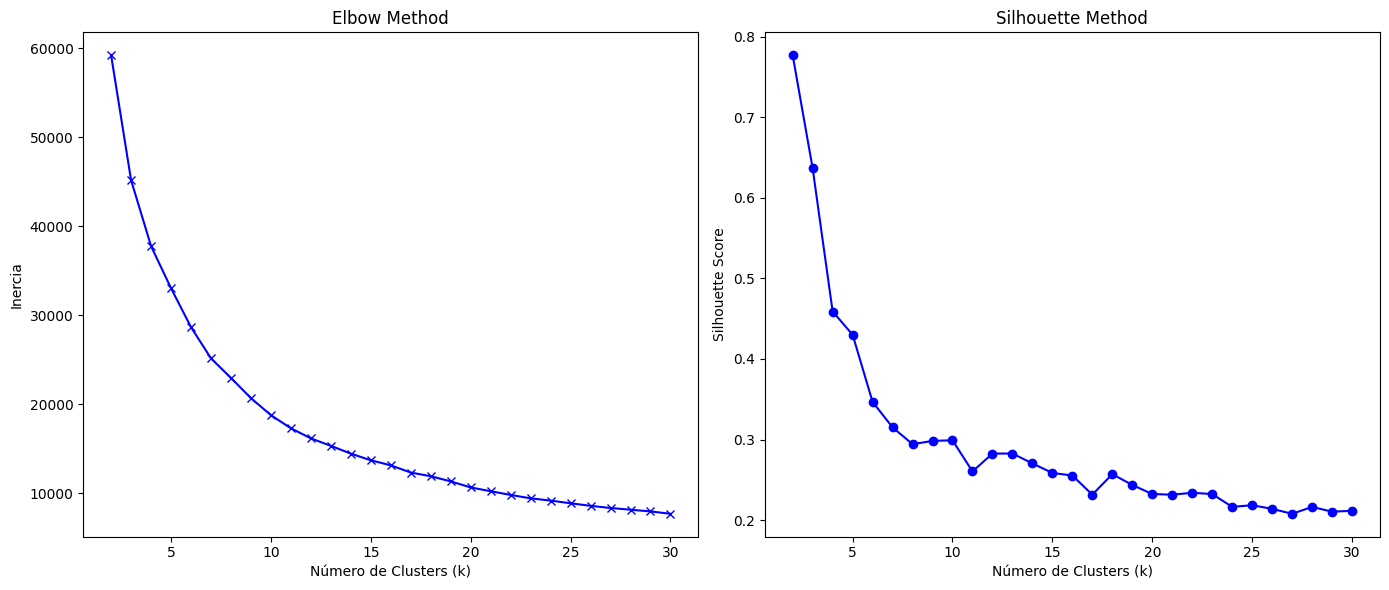

In [71]:
km_m.plot_elbow_silhouette(scaled_df, 30)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


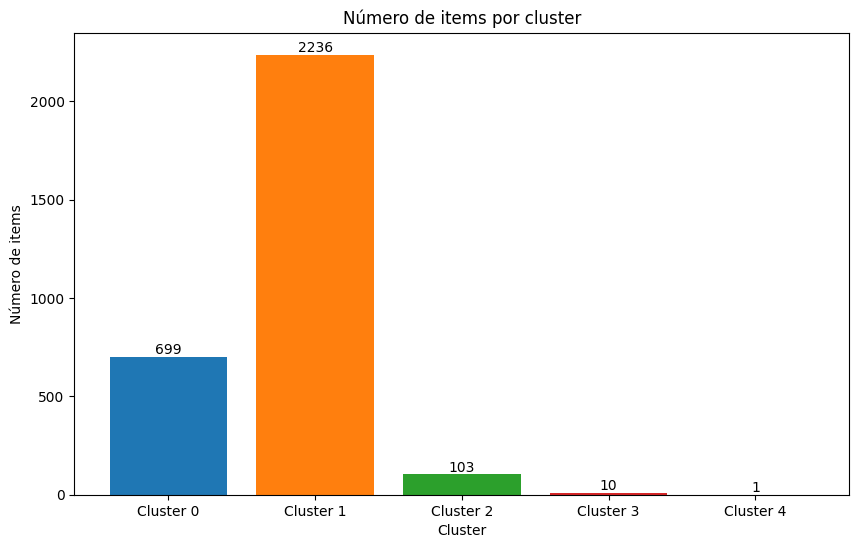

,COUNT(sales),MAX(sales.raw_earn),MAX(sales.units),MEAN(sales.raw_earn),MEAN(sales.units),MIN(sales.raw_earn),MIN(sales.units),SUM(sales.raw_earn),PERCENTILE(MAX(sales.raw_earn)),PERCENTILE(MAX(sales.units)),PERCENTILE(MEAN(sales.raw_earn)),PERCENTILE(MEAN(sales.units)),PERCENTILE(MIN(sales.raw_earn)),PERCENTILE(MIN(sales.units)),PERCENTILE(SUM(sales.raw_earn)),PERCENTILE(SUM(sales.units)),Cluster
item,,,,,,,,,,,,,,,,,
ACCESORIES_1_001,1185,142.82,13.0,37.996321,3.454008,10.99,1.0,45025.64,0.474254,0.144474,0.674319,0.260741,0.937193,0.497376,0.515251,0.232535,1
ACCESORIES_1_002,1899,190.08,36.0,14.061259,2.664034,2.66,1.0,26702.33,0.615612,0.537061,0.181699,0.163004,0.419482,0.497376,0.311906,0.294523,1
ACCESORIES_1_003,665,63.20,16.0,8.499383,2.157895,1.29,1.0,5652.09,0.137422,0.207773,0.066251,0.095441,0.149065,0.497376,0.034438,0.040013,1
ACCESORIES_1_004,2512,506.04,82.0,93.700155,15.595143,5.01,1.0,235374.79,0.898983,0.785831,0.914070,0.831748,0.705477,0.497376,0.944572,0.878649,0
ACCESORIES_1_005,2134,141.61,42.0,26.082737,6.851453,3.30,1.0,55660.56,0.469334,0.594785,0.490653,0.562807,0.499672,0.497376,0.603805,0.642834,1


In [72]:
# Apreciamos varias opciones 5 o 6
optimal_k = 5

kmeans_model, feature_matrix_with_clusters = km_m.apply_kmeans_and_plot(optimal_k, scaled_df, feature_matrix_renamed)

feature_matrix_with_clusters.head(5)

### Analisis

#### PCAs

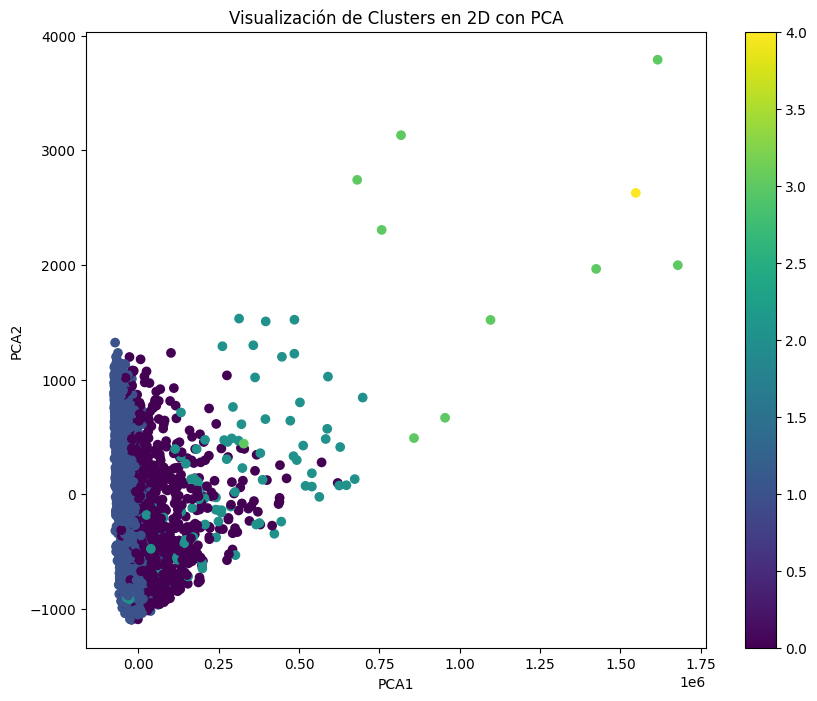

,PCA1,PCA2,Cluster
0,-30732.627601,390.857963,1
1,-49054.206116,-343.029460,1
2,-70107.232284,829.530236,1
3,159619.129533,-557.558487,0
4,-20095.803970,-533.020684,1


In [73]:
pca_df = km_m.pca_visualization_2d(feature_matrix_with_clusters)

display(pca_df.head())

Principal Component 1: 1.00


array([0.99996994])

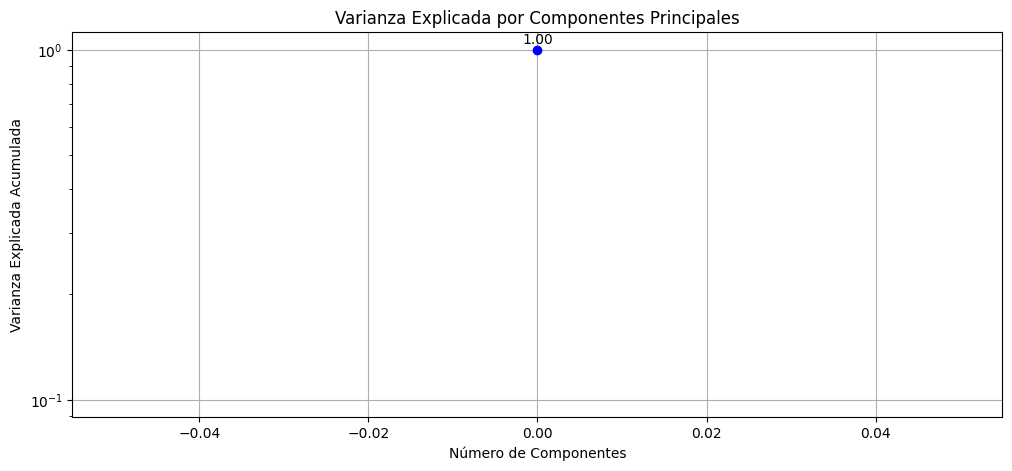

In [74]:
explained_variance = km_m.pca_variance_plot(feature_matrix_with_clusters, 1)

display(explained_variance)

#### Importancia caracteristicas

Cat cols: 0
Num cols: 16


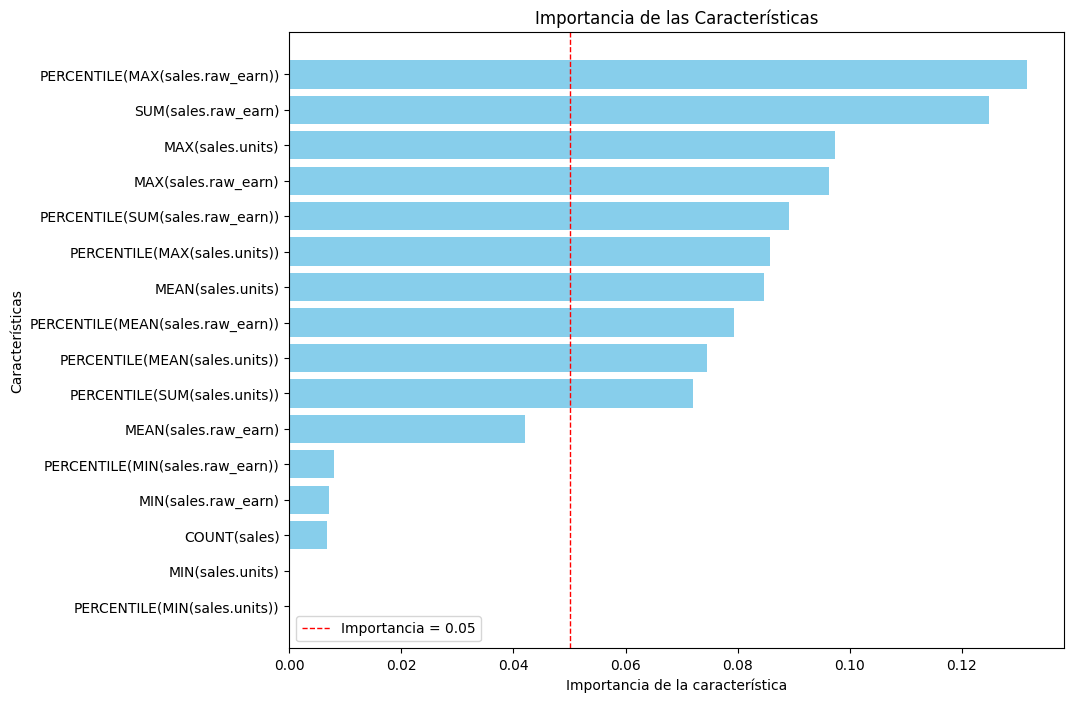

,Feature,Importance
0,PERCENTILE(MAX(sales.raw_earn)),0.131677
1,SUM(sales.raw_earn),0.124765
2,MAX(sales.units),0.097363
3,MAX(sales.raw_earn),0.096301
4,PERCENTILE(SUM(sales.raw_earn)),0.089231
5,PERCENTILE(MAX(sales.units)),0.085814
6,MEAN(sales.units),0.084766
7,PERCENTILE(MEAN(sales.raw_earn)),0.079256
8,PERCENTILE(MEAN(sales.units)),0.074601
9,PERCENTILE(SUM(sales.units)),0.071956


In [75]:
# Preprocesamos datos
cluster_col='Cluster'
cols_to_scale = feature_matrix_with_clusters.columns.tolist()
df_clusters = feature_matrix_with_clusters[[cluster_col]].copy().reset_index(drop=True)
cols_to_scale.remove(cluster_col) # Columna Objetivo
preprocessed_df = pm.preprocess_features(feature_matrix_with_clusters[cols_to_scale])

# Combinar los DataFrames basándose en la columna 'Index'
preprocessed_df = pd.concat([preprocessed_df, df_clusters], axis=1)

clusters = kmeans_model.labels_

# sales_importance_df = km_m.get_feature_importances(feature_matrix_with_clusters, clusters, imp_threshold=0.05)
IMPORTANCE_THRES=0.05
sales_importance_df = km_m.get_feature_importances(preprocessed_df, clusters, imp_threshold=IMPORTANCE_THRES)

display(sales_importance_df[sales_importance_df['Importance'] >= 0.05])

### Dimension Redux

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


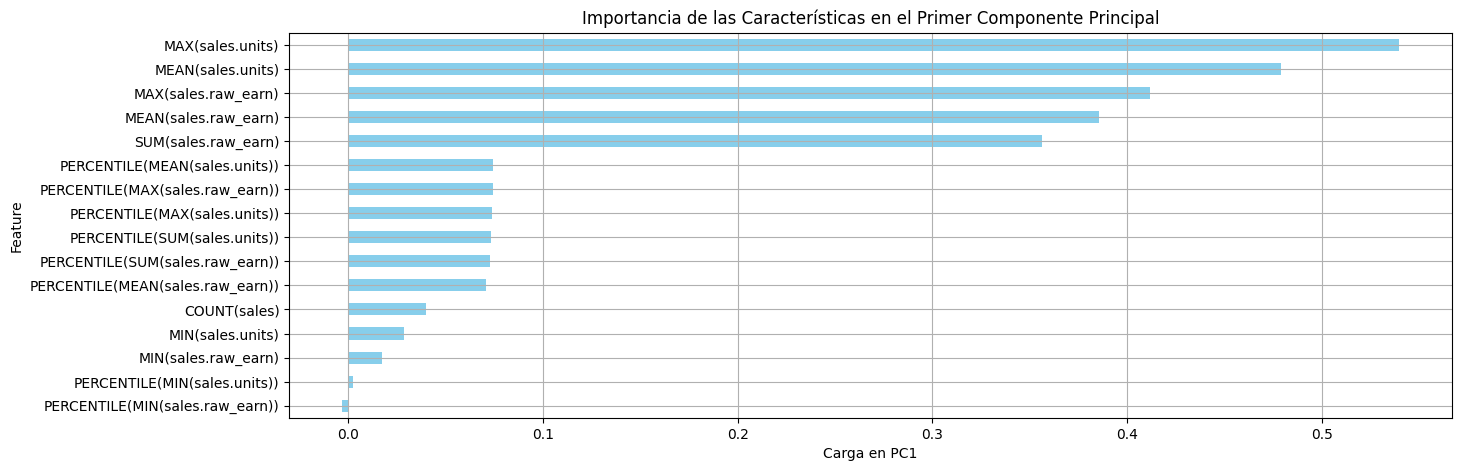

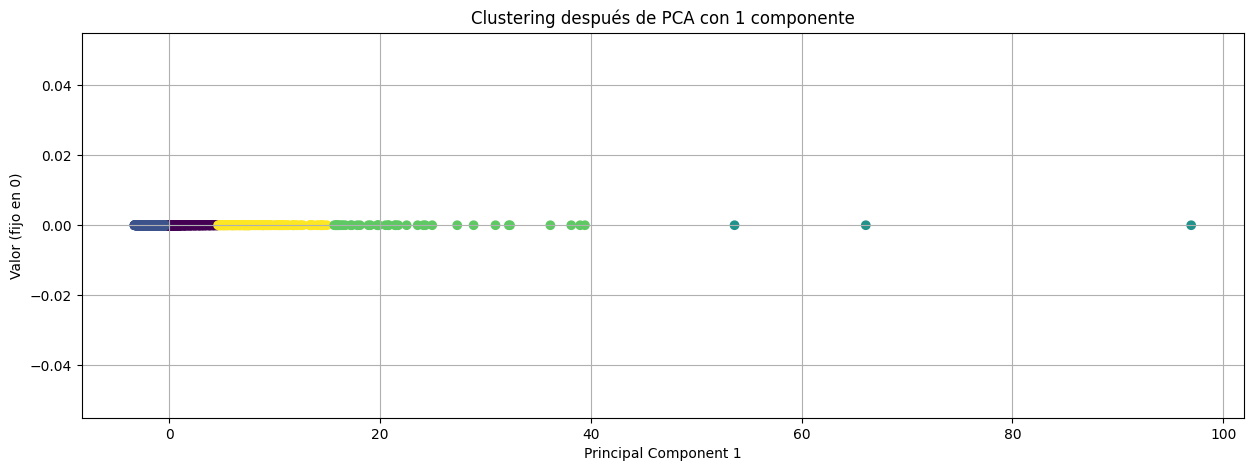

In [76]:
pca_df, importance_df = km_m.redux_dimensions_pca_and_cluster(preprocessed_df, n_clusters=optimal_k, n_components=1)


In [77]:
# El segundo componente es residual
# pca_df, importance_df = km_m.redux_dimensions_pca_and_cluster(preprocessed_df, n_clusters=optimal_k, n_components=2)

## Descripcion de los clusters

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,COUNT(sales),MAX(sales.raw_earn),MAX(sales.units),MEAN(sales.raw_earn),MEAN(sales.units),MIN(sales.raw_earn),MIN(sales.units),SUM(sales.raw_earn),PERCENTILE(MAX(sales.raw_earn)),PERCENTILE(MAX(sales.units)),PERCENTILE(MEAN(sales.raw_earn)),PERCENTILE(MEAN(sales.units)),PERCENTILE(MIN(sales.raw_earn)),PERCENTILE(MIN(sales.units)),PERCENTILE(SUM(sales.raw_earn)),PERCENTILE(SUM(sales.units)),PC1,Cluster
0,-0.496040,-0.033346,-0.392157,0.388096,-0.299973,2.050667,0.0,0.026427,-0.051837,-0.708633,0.348425,-0.479003,0.877055,0.0,0.030184,-0.535433,-1.677316,1
1,0.210891,0.230190,0.058824,-0.429012,-0.399820,-0.170667,0.0,-0.269028,0.230971,0.074232,-0.637139,-0.674541,-0.160750,0.0,-0.376640,-0.411417,-1.827710,1
2,-1.010891,-0.477332,-0.333333,-0.618886,-0.463792,-0.536000,0.0,-0.608455,-0.725722,-0.582407,-0.868110,-0.809711,-0.702827,0.0,-0.931759,-0.920604,-2.832811,1
3,0.817822,1.992082,0.960784,2.289743,1.234579,0.456000,0.0,3.095729,0.797900,0.570307,0.828084,0.663386,0.412558,0.0,0.889108,0.757218,2.906518,0
4,0.443564,-0.040094,0.176471,-0.018616,0.129440,0.000000,0.0,0.197911,-0.061680,0.189339,-0.019029,0.125328,0.000000,0.0,0.207349,0.285433,-1.101992,1


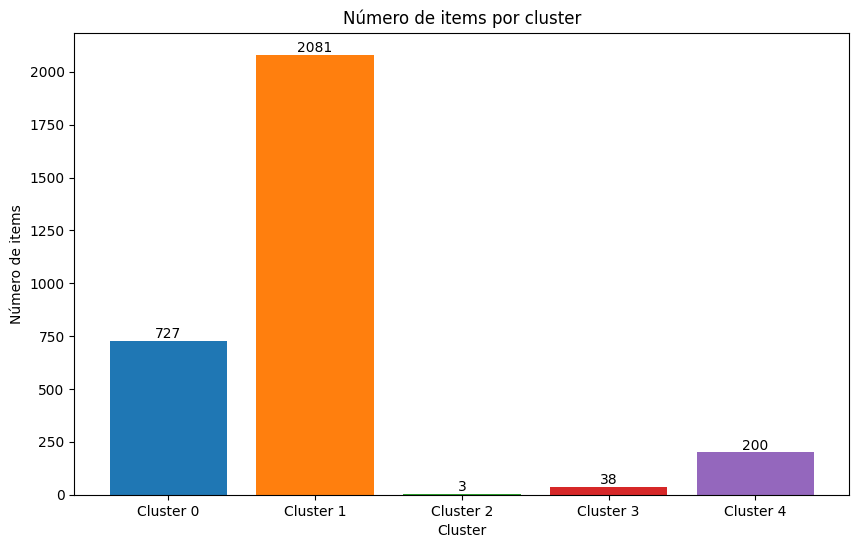

In [78]:
# Ejecutar PCA y clustering
optimal_k = 5
n_components = 1

df_with_pca, importance_df = km_m.pca_and_cluster(scaled_df, n_clusters=optimal_k, n_components=n_components)

# Mostrar el DataFrame con PCA y clustering
display(df_with_pca.head(5))

# Graficar la cantidad de items por cluster
# km_m.plot_items_per_cluster(df_with_pca)
show_clusters = km_m.plot_cluster_sizes(df_with_pca)

### Mostrar descripciones

In [79]:
# Seleccionamos las features según su importancia en el componente principal
importance_df_filt = importance_df[importance_df['Loading_PC1'] >= 0.05]

importance_df_filt

,Feature,Loading_PC1
2,MAX(sales.units),0.539380
4,MEAN(sales.units),0.478880
1,MAX(sales.raw_earn),0.411440
3,MEAN(sales.raw_earn),0.385605
7,SUM(sales.raw_earn),0.356079
11,PERCENTILE(MEAN(sales.units)),0.074421
8,PERCENTILE(MAX(sales.raw_earn)),0.074310
9,PERCENTILE(MAX(sales.units)),0.073919
15,PERCENTILE(SUM(sales.units)),0.073276
14,PERCENTILE(SUM(sales.raw_earn)),0.072699


In [80]:
# Crear y mostrar descripciones de los clusters
description_df = km_m.create_cluster_descriptions(df_with_pca, importance_df_filt)
print('###########################################################')
print('Descripcion de los clusters')
print('###########################################################')
display(description_df.T)

###########################################################
Descripcion de los clusters
###########################################################


,MAX(sales.units),MEAN(sales.units),MAX(sales.raw_earn),MEAN(sales.raw_earn),SUM(sales.raw_earn),PERCENTILE(MEAN(sales.units)),PERCENTILE(MAX(sales.raw_earn)),PERCENTILE(MAX(sales.units)),PERCENTILE(SUM(sales.units)),PERCENTILE(SUM(sales.raw_earn)),PERCENTILE(MEAN(sales.raw_earn))
1,-0.097464,-0.110059,-0.150172,-0.137249,-0.138817,-0.280465,-0.282130,-0.277997,-0.275350,-0.272347,-0.265665
0,1.287051,1.209474,1.174128,1.104176,1.089306,0.517292,0.529630,0.512405,0.505339,0.507717,0.498828
4,5.012059,4.361010,3.671129,3.306059,3.429730,0.841706,0.810930,0.842379,0.836214,0.789626,0.752949
3,12.459236,11.419692,10.838187,10.294737,8.494957,0.953637,0.970990,0.961215,0.931241,0.966311,0.963600
2,41.986928,39.759862,28.204669,26.415567,26.551615,0.998688,0.995626,0.995204,0.997594,0.999344,0.997813


In [81]:
# Añadimos clusters a df_items
df_items = df_items.reset_index(drop=True) # Recuperamos indices originales

df_items_with_clusters = df_items.merge(df_with_pca[['Cluster']], left_index=True, right_index=True)

df_items_with_clusters.head()

,item,category,department,Cluster
0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,1
1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,1
2,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,1
3,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,0
4,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,1


### Asignacion clusters a items

In [82]:
# Crear dataframe con las descripciones de los clusters
cluster_summary = {
    0: {
        'cluster_name': 'Low Performance',
        'description': 'Productos con rendimiento muy bajo en todas las métricas, con pocas ventas y bajas ganancias.'
    },
    1: {
        'cluster_name': 'Moderate Performance',
        'description': 'Productos con rendimiento moderado, presentando ventas y ganancias cercanas al promedio.'
    },
    2: {
        'cluster_name': 'High Performance',
        'description': 'Productos con alto rendimiento, con ventas y ganancias por encima del promedio.'
    },
    3: {
        'cluster_name': 'Top Performance',
        'description': 'Productos con el mejor rendimiento, con las mayores ventas y ganancias en todas las métricas.'
    },
    4: {
        'cluster_name': 'Moderate-High Performance',
        'description': 'Productos con buen rendimiento, con ventas y ganancias altas, pero sin llegar al nivel del grupo de mejor desempeño.'
    }
}


cluster_summary_df = pd.DataFrame.from_dict(cluster_summary, orient='index')

# Asumiendo que tienes un dataframe `items_df` que tiene una columna 'cluster' con los números de cluster
# Realiza un merge con el resumen de clusters para añadir los nombres y descripciones al dataframe original
items_with_cluster_info = df_items_with_clusters.merge(cluster_summary_df, left_on='Cluster', right_index=True, how='left')

# Resultado: `items_with_cluster_info` tendrá las columnas adicionales 'cluster_name' y 'description'
display(items_with_cluster_info.head())

,item,category,department,Cluster,cluster_name,description
0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,1,Moderate Performance,"Productos con rendimiento moderado, presentand..."
1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,1,Moderate Performance,"Productos con rendimiento moderado, presentand..."
2,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,1,Moderate Performance,"Productos con rendimiento moderado, presentand..."
3,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,0,Low Performance,Productos con rendimiento muy bajo en todas la...
4,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,1,Moderate Performance,"Productos con rendimiento moderado, presentand..."


## Guardamos CSV

In [83]:
# Guardamos df como csv
from google.colab import files

file_name = 'items_clusters_sales_performance.csv'

# Exportar DataFrame a CSV (reemplaza 'df' por el nombre de tu DataFrame)
items_with_cluster_info.to_csv(file_name, index=False)

# Descargar el archivo CSV
files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **PRODUCTOS: RANGO DE PRECIOS**
___
___

## Selección caracteristicas

In [84]:
# V3
substrings = ['(sales)', '.sell_price)'] # Nos quedamos solo con las que afectan al precio de venta

feat_selected = fcm.select_features(features_descriptions, substrings)

print(f'Length Feats Selected: {len(feat_selected)}')
# display(feat_selected)

feature_matrix_selected = feature_matrix[feat_selected].copy()

# display(feature_matrix_selected.head(5))

# Aplicar filtros a las caracteristicas creadas
# Remove low information, highly correlated, highly null and single value features
filtered_feature_matrix = fcm.filter_feature_matrix(feature_matrix_selected)

# Renombrar características si es necesario # Evitamos este paso de momento
# feature_matrix_renamed = fcm.rename_features(filtered_feature_matrix, price_range_features)
feature_matrix_renamed = filtered_feature_matrix.copy()

display(feature_matrix_renamed.head(5))

Length Feats Selected: 12
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Shape before filtering: 12
Shape after filtering: 10
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


,COUNT(sales),MAX(sales.sell_price),MEAN(sales.sell_price),MIN(sales.sell_price),STD(sales.sell_price),SUM(sales.sell_price),PERCENTILE(MAX(sales.sell_price)),PERCENTILE(MIN(sales.sell_price)),PERCENTILE(STD(sales.sell_price)),PERCENTILE(SUM(sales.sell_price))
item,,,,,,,,,,
ACCESORIES_1_001,1185,12.74,11.017688,6.65,0.192594,13055.96,0.919974,0.859626,0.607740,0.808462
ACCESORIES_1_002,1899,5.28,5.276540,2.66,0.090296,10020.15,0.585766,0.543785,0.369629,0.702853
ACCESORIES_1_003,665,3.95,3.937880,1.25,0.180185,2618.69,0.451132,0.252050,0.583142,0.135782
ACCESORIES_1_004,2512,6.17,5.985088,5.01,0.266543,15034.54,0.652017,0.768777,0.747458,0.856346
ACCESORIES_1_005,2134,4.10,3.825309,2.65,0.226915,8163.21,0.462283,0.540997,0.679567,0.602821


## Preprocesamiento

In [85]:
scaled_df = pm.preprocess_features(feature_matrix_renamed)

Cat cols: 0
Num cols: 10


In [86]:
scaled_df.head(5)

,COUNT(sales),MAX(sales.sell_price),MEAN(sales.sell_price),MIN(sales.sell_price),STD(sales.sell_price),SUM(sales.sell_price),PERCENTILE(MAX(sales.sell_price)),PERCENTILE(MIN(sales.sell_price)),PERCENTILE(STD(sales.sell_price)),PERCENTILE(SUM(sales.sell_price))
0,-0.496040,1.808696,1.499780,1.144809,0.231308,0.863530,0.846918,0.723026,0.215223,0.616798
1,0.210891,0.186957,0.240400,0.054645,-0.236953,0.462539,0.171637,0.089474,-0.261155,0.405512
2,-1.010891,-0.102174,-0.053249,-0.330601,0.174510,-0.515099,-0.100398,-0.495724,0.166010,-0.729003
3,0.817822,0.380435,0.395827,0.696721,0.569805,1.124875,0.305500,0.540789,0.494751,0.712598
4,0.443564,-0.069565,-0.077942,0.051913,0.388411,0.217261,-0.077866,0.083882,0.358924,0.205381


## Kmeans

### Elbow & Silhoutte

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

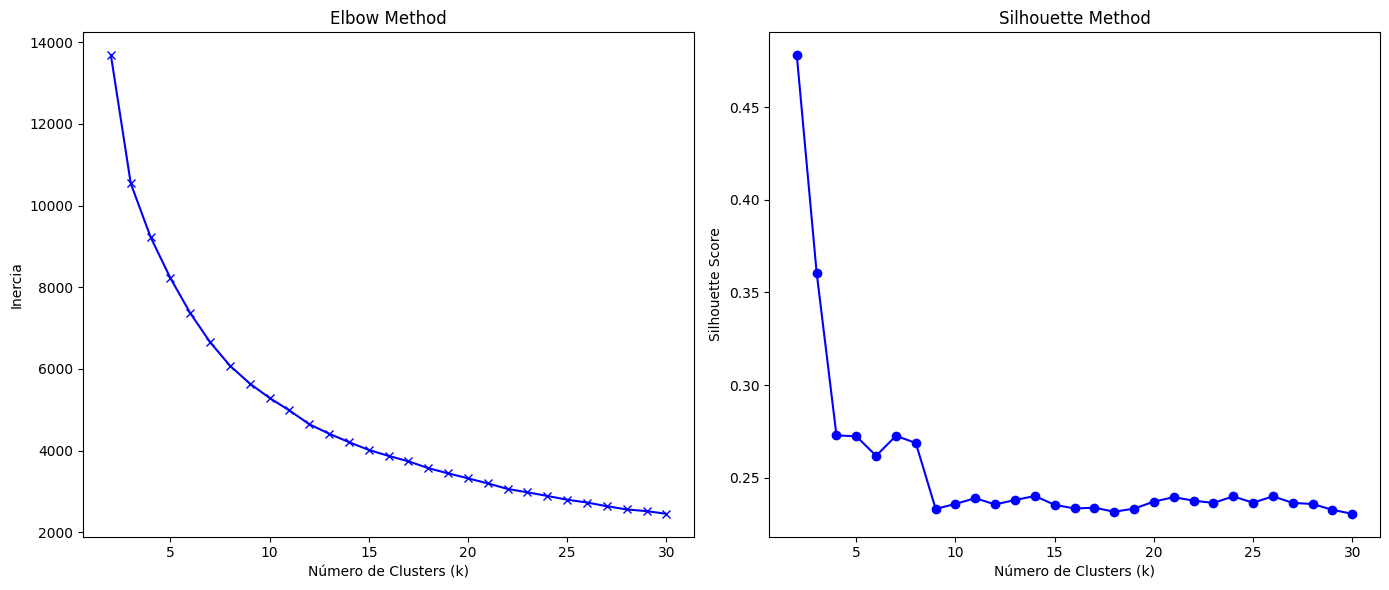

In [87]:
km_m.plot_elbow_silhouette(scaled_df, 30)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


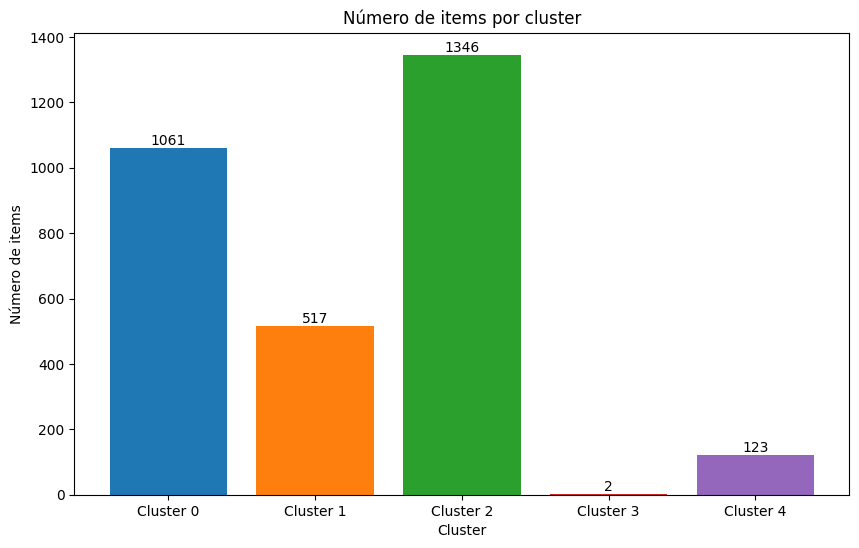

,COUNT(sales),MAX(sales.sell_price),MEAN(sales.sell_price),MIN(sales.sell_price),STD(sales.sell_price),SUM(sales.sell_price),PERCENTILE(MAX(sales.sell_price)),PERCENTILE(MIN(sales.sell_price)),PERCENTILE(STD(sales.sell_price)),PERCENTILE(SUM(sales.sell_price)),Cluster
item,,,,,,,,,,,
ACCESORIES_1_001,1185,12.74,11.017688,6.65,0.192594,13055.96,0.919974,0.859626,0.607740,0.808462,1
ACCESORIES_1_002,1899,5.28,5.276540,2.66,0.090296,10020.15,0.585766,0.543785,0.369629,0.702853,0
ACCESORIES_1_003,665,3.95,3.937880,1.25,0.180185,2618.69,0.451132,0.252050,0.583142,0.135782,2
ACCESORIES_1_004,2512,6.17,5.985088,5.01,0.266543,15034.54,0.652017,0.768777,0.747458,0.856346,0
ACCESORIES_1_005,2134,4.10,3.825309,2.65,0.226915,8163.21,0.462283,0.540997,0.679567,0.602821,0


In [88]:
# Apreciamos varias opciones 5 o 6
optimal_k = 5

kmeans_model, feature_matrix_with_clusters = km_m.apply_kmeans_and_plot(optimal_k, scaled_df, feature_matrix_renamed)

feature_matrix_with_clusters.head(5)

### Analisis

#### PCAs

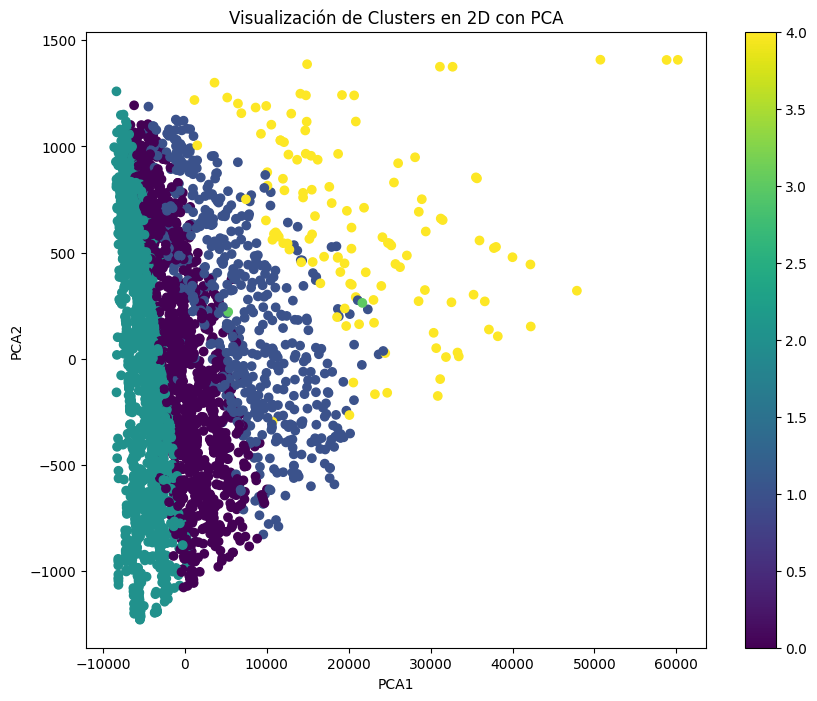

,PCA1,PCA2,Cluster
0,4305.740023,568.500084,1
1,1288.812658,-221.549780,0
2,-6141.304411,826.175588,2
3,6317.016607,-708.421904,0
4,-561.640228,-503.110216,0


In [89]:
pca_df = km_m.pca_visualization_2d(feature_matrix_with_clusters)

display(pca_df.head())

Principal Component 1: 0.99


array([0.99388715])

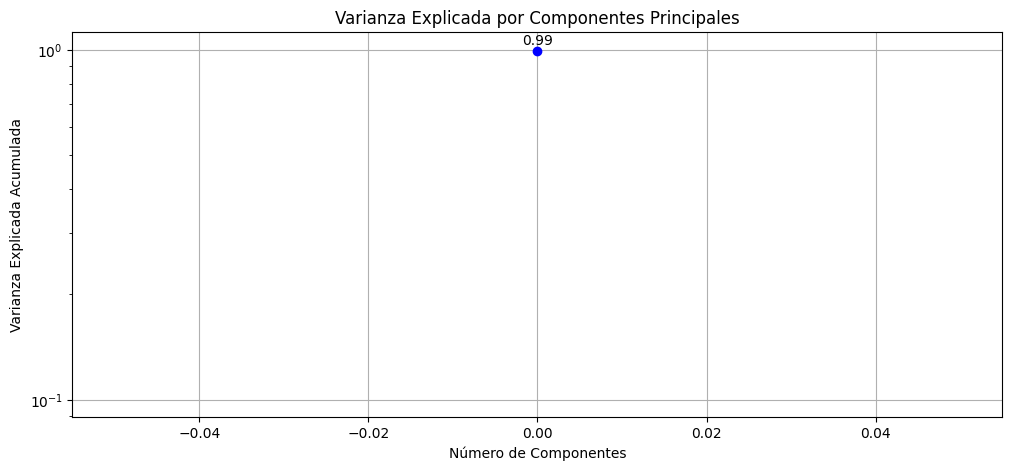

In [90]:
explained_variance = km_m.pca_variance_plot(feature_matrix_with_clusters, 1)

display(explained_variance)

#### Importancia caracteristicas

Cat cols: 0
Num cols: 10


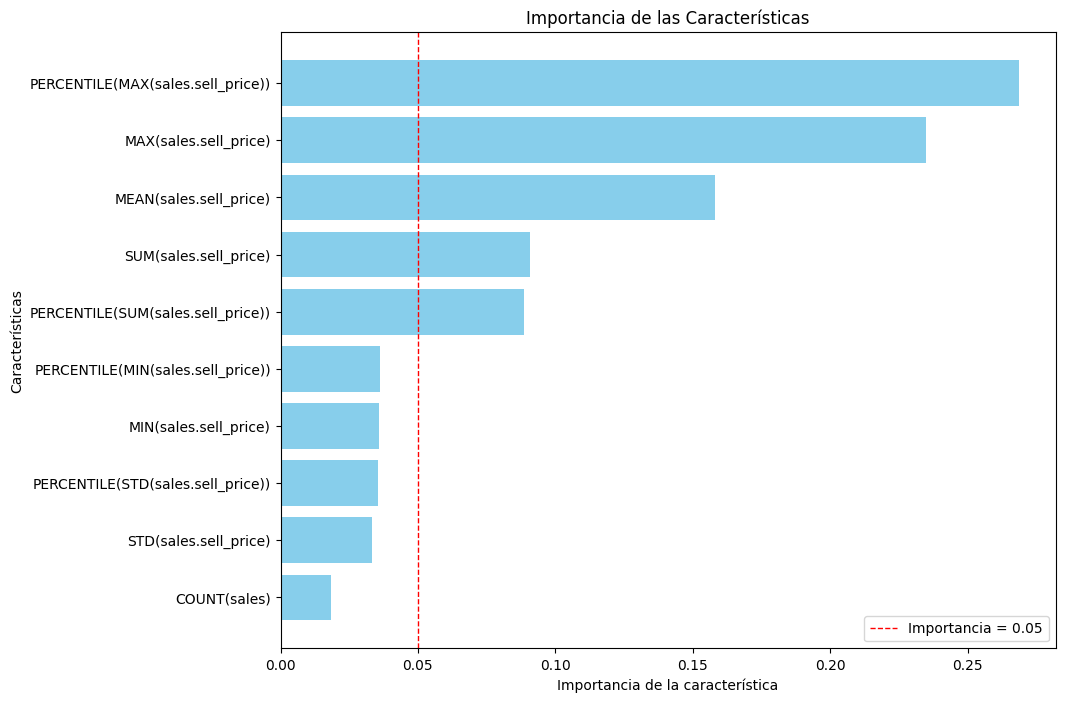

,Feature,Importance
0,PERCENTILE(MAX(sales.sell_price)),0.268594
1,MAX(sales.sell_price),0.234997
2,MEAN(sales.sell_price),0.158077
3,SUM(sales.sell_price),0.090832
4,PERCENTILE(SUM(sales.sell_price)),0.088599
5,PERCENTILE(MIN(sales.sell_price)),0.036138
6,MIN(sales.sell_price),0.035674
7,PERCENTILE(STD(sales.sell_price)),0.035391
8,STD(sales.sell_price),0.033174
9,COUNT(sales),0.018524


In [91]:
# Preprocesamos datos
cluster_col='Cluster'
cols_to_scale = feature_matrix_with_clusters.columns.tolist()
df_clusters = feature_matrix_with_clusters[[cluster_col]].copy().reset_index(drop=True)
cols_to_scale.remove(cluster_col) # Columna Objetivo
preprocessed_df = pm.preprocess_features(feature_matrix_with_clusters[cols_to_scale])

# Combinar los DataFrames basándose en la columna 'Index'
preprocessed_df = pd.concat([preprocessed_df, df_clusters], axis=1)

clusters = kmeans_model.labels_

IMPORTANCE_THRES=0.05
prices_importance_df = km_m.get_feature_importances(preprocessed_df, clusters, imp_threshold=IMPORTANCE_THRES)

display(prices_importance_df.head(10))

### Dimension Redux

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


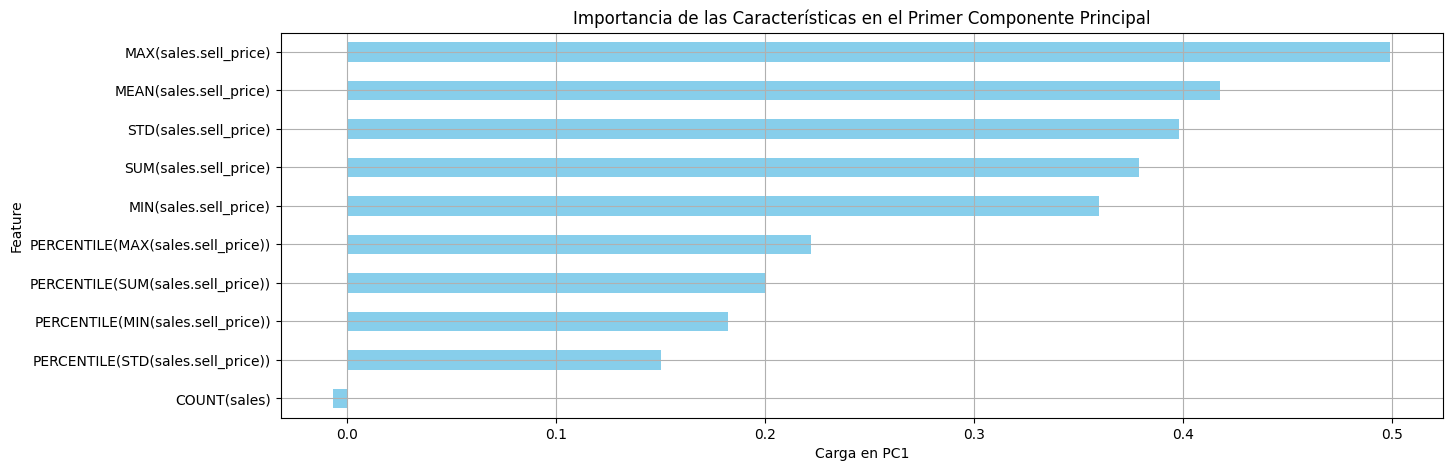

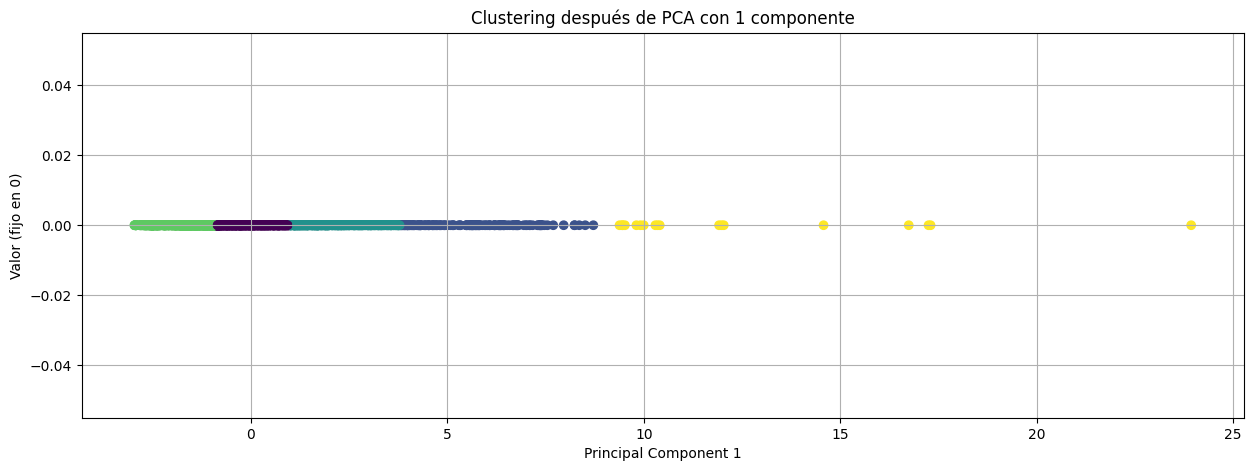

In [92]:
pca_df, importance_df = km_m.redux_dimensions_pca_and_cluster(preprocessed_df, n_clusters=optimal_k, n_components=1)

In [93]:
# El segundo componente es residual
# pca_df, importance_df = km_m.redux_dimensions_pca_and_cluster(preprocessed_df, n_clusters=optimal_k, n_components=2)

## Descripcion de los clusters

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,COUNT(sales),MAX(sales.sell_price),MEAN(sales.sell_price),MIN(sales.sell_price),STD(sales.sell_price),SUM(sales.sell_price),PERCENTILE(MAX(sales.sell_price)),PERCENTILE(MIN(sales.sell_price)),PERCENTILE(STD(sales.sell_price)),PERCENTILE(SUM(sales.sell_price)),PC1,Cluster
0,-0.496040,1.808696,1.499780,1.144809,0.231308,0.863530,0.846918,0.723026,0.215223,0.616798,2.186028,2
1,0.210891,0.186957,0.240400,0.054645,-0.236953,0.462539,0.171637,0.089474,-0.261155,0.405512,-0.263346,0
2,-1.010891,-0.102174,-0.053249,-0.330601,0.174510,-0.515099,-0.100398,-0.495724,0.166010,-0.729003,-1.198378,3
3,0.817822,0.380435,0.395827,0.696721,0.569805,1.124875,0.305500,0.540789,0.494751,0.712598,0.984530,2
4,0.443564,-0.069565,-0.077942,0.051913,0.388411,0.217261,-0.077866,0.083882,0.358924,0.205381,-0.374128,0


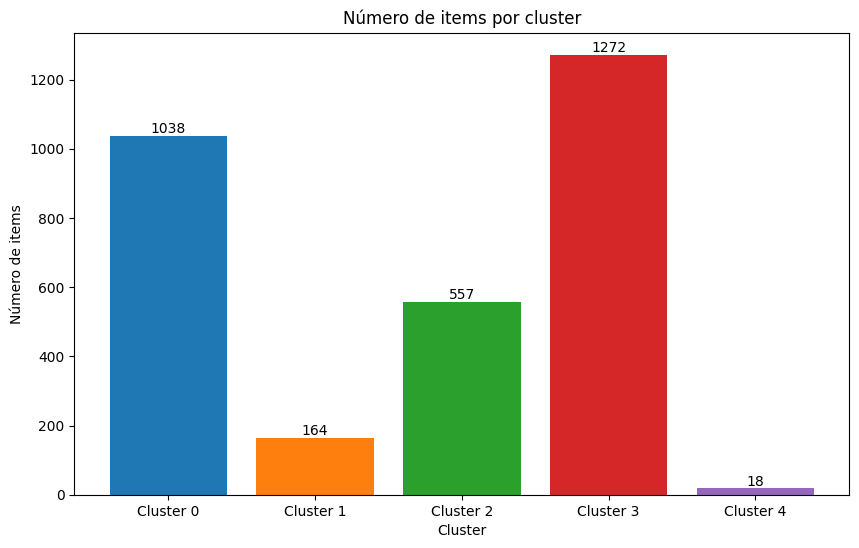

In [94]:
# Ejecutar PCA y clustering
optimal_k = 5
n_components = 1

df_with_pca, importance_df = km_m.pca_and_cluster(scaled_df, n_clusters=optimal_k, n_components=n_components)

# Mostrar el DataFrame con PCA y clustering
display(df_with_pca.head(5))

# Graficar la cantidad de items por cluster
# km_m.plot_items_per_cluster(df_with_pca)
show_clusters = km_m.plot_cluster_sizes(df_with_pca)

### Mostrar Descripcions

In [95]:
# Seleccionamos las features según su importancia en el componente principal
importance_df_filt = importance_df[importance_df['Loading_PC1'] >= 0.05]

importance_df_filt

# Crear y mostrar descripciones de los clusters
description_df = km_m.create_cluster_descriptions(df_with_pca, importance_df_filt)
print('###########################################################')
print('Descripcion de los clusters')
print('###########################################################')
display(description_df)

###########################################################
Descripcion de los clusters
###########################################################


,2,0,3,1,4
MAX(sales.sell_price),1.212591,0.225752,-0.415094,3.071129,7.756401
MEAN(sales.sell_price),1.136841,0.220788,-0.393233,2.826772,5.474077
STD(sales.sell_price),1.013642,0.173509,-0.256406,2.285075,7.285207
SUM(sales.sell_price),1.094182,0.239740,-0.368300,2.664831,3.709536
MIN(sales.sell_price),1.048386,0.263072,-0.230730,2.514411,5.347753
PERCENTILE(MAX(sales.sell_price)),0.689093,0.168070,-0.576924,0.936196,0.999356
PERCENTILE(SUM(sales.sell_price)),0.596150,0.150508,-0.510707,0.881878,0.928223
PERCENTILE(MIN(sales.sell_price)),0.555860,0.110265,-0.447872,0.820637,0.947624
PERCENTILE(STD(sales.sell_price)),0.433980,0.051422,-0.335904,0.699035,0.973607


### Asignacion clusters a items

In [96]:
# Añadimos clusters a df_items
df_items = df_items.reset_index(drop=True) # Recuperamos indices originales

df_items_with_clusters = df_items.merge(df_with_pca[['Cluster']], left_index=True, right_index=True)

df_items_with_clusters.head()

,item,category,department,Cluster
0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,2
1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,0
2,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,3
3,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,2
4,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,0


In [97]:
# Crear dataframe con las descripciones de los clusters
cluster_summary = {
    0: {
        'cluster_name': 'Low Price',
        'description': 'Productos de precio muy bajo en todas las métricas, con poca variación en los precios.'
    },
    1: {
        'cluster_name': 'High Price',
        'description': 'Productos con precios altos, buena variación en los precios, indicando productos de calidad o premium.'
    },
    2: {
        'cluster_name': 'Slightly Above Average Price',
        'description': 'Productos con precios ligeramente por encima del promedio, manteniendo una estabilidad en los precios.'
    },
    3: {
        'cluster_name': 'Very Low or Discounted Price',
        'description': 'Productos con precios muy bajos o negativos, posiblemente debido a descuentos o promociones agresivas.'
    },
    4: {
        'cluster_name': 'Premium Price',
        'description': 'Productos con precios muy altos, indicando artículos de lujo o premium con gran variabilidad en los precios.'
    }
}


cluster_summary_df = pd.DataFrame.from_dict(cluster_summary, orient='index')

# Asumiendo que tienes un dataframe `items_df` que tiene una columna 'cluster' con los números de cluster
# Realiza un merge con el resumen de clusters para añadir los nombres y descripciones al dataframe original
items_with_cluster_info = df_items_with_clusters.merge(cluster_summary_df, left_on='Cluster', right_index=True, how='left')

# Resultado: `items_with_cluster_info` tendrá las columnas adicionales 'cluster_name' y 'description'
display(items_with_cluster_info.head())

,item,category,department,Cluster,cluster_name,description
0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,2,Slightly Above Average Price,Productos con precios ligeramente por encima d...
1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,0,Low Price,Productos de precio muy bajo en todas las métr...
2,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,3,Very Low or Discounted Price,"Productos con precios muy bajos o negativos, p..."
3,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,2,Slightly Above Average Price,Productos con precios ligeramente por encima d...
4,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,0,Low Price,Productos de precio muy bajo en todas las métr...


## Guardamos CSV

In [98]:
# Guardamos df como csv
from google.colab import files

file_name = 'items_clusters_price_range.csv'

# Exportar DataFrame a CSV (reemplaza 'df' por el nombre de tu DataFrame)
items_with_cluster_info.to_csv(file_name, index=False)

# Descargar el archivo CSV
files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **PRODUCTOS: EVENTOS**  
  
**Efecto de eventos en ventas de productos**
___
___

## Creacion caracteristicas

In [101]:
# Añadir año y semana a calendar para poder añadir eventos a weekly sales
df_cal['fecha'] = pd.to_datetime(df_cal['fecha'])

df_cal['year'] = df_cal['fecha'].dt.year
df_cal['week'] = df_cal['fecha'].dt.isocalendar().week

# Añadir la columna event de df_cal a df_ws usando las columnas year y week (añadir estas dos tambien a df_ws)
df_ws = df_ws.merge(df_cal[['year', 'week', 'event']], on=['year', 'week'], how='left')

# Rellenar NaN columna event de df_ws con 'None' (str)
df_ws['event'] = df_ws['event'].fillna('None')

In [104]:
display(df_items.head())
display(df_shops.head())
display(df_ws.head())

,item,category,department
0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1
1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1
2,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1
3,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1
4,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1


,store_code,region,store
NYC_1,NYC_1,New York,Greenwich_Village
NYC_2,NYC_2,New York,Harlem
NYC_3,NYC_3,New York,Tribeca
NYC_4,NYC_4,New York,Brooklyn
BOS_1,BOS_1,Boston,South_End


,id,item,store_code,year,week,units,sell_price,raw_earn,event
0,586148,ACCESORIES_1_002,BOS_3,2012,1,2.0,5.28,10.56,None
1,586149,ACCESORIES_1_002,NYC_1,2012,1,1.0,5.28,5.28,None
2,586150,ACCESORIES_1_002,NYC_2,2012,1,1.0,5.28,5.28,None
3,586151,ACCESORIES_1_002,NYC_3,2012,1,2.0,5.28,10.56,None
4,586152,ACCESORIES_1_002,NYC_4,2012,1,1.0,5.28,5.28,None


In [113]:
# OHE para columna event en df_ws usando sklearn.preprocessing
from sklearn.preprocessing import OneHotEncoder

# Seleccionar la columna 'event' para codificar
events = df_ws[['event']]

# Crear el OneHotEncoder
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

# Ajustar y transformar los eventos con OHE
event_encoded = ohe.fit_transform(events)

# Crear un DataFrame con las columnas codificadas
event_encoded_df = pd.DataFrame(event_encoded, columns=ohe.get_feature_names_out(['event']))

# Concatenar con el DataFrame original de ventas
df_ws_ohe = pd.concat([df_ws.reset_index(drop=True), event_encoded_df], axis=1)

# Ver el resultado
df_ws_ohe.head()


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,id,item,store_code,year,week,units,sell_price,raw_earn,event,event_Easter,event_NewYear,event_None,event_Ramadan starts,event_SuperBowl,event_Thanksgiving
0,586148,ACCESORIES_1_002,BOS_3,2012,1,2.0,5.28,10.56,None,0.0,0.0,1.0,0.0,0.0,0.0
1,586149,ACCESORIES_1_002,NYC_1,2012,1,1.0,5.28,5.28,None,0.0,0.0,1.0,0.0,0.0,0.0
2,586150,ACCESORIES_1_002,NYC_2,2012,1,1.0,5.28,5.28,None,0.0,0.0,1.0,0.0,0.0,0.0
3,586151,ACCESORIES_1_002,NYC_3,2012,1,2.0,5.28,10.56,None,0.0,0.0,1.0,0.0,0.0,0.0
4,586152,ACCESORIES_1_002,NYC_4,2012,1,1.0,5.28,5.28,None,0.0,0.0,1.0,0.0,0.0,0.0


In [114]:
import featuretools as ft

# Crear un EntitySet
es = ft.EntitySet(id='sales_data')

# Agregar entidades
es = es.add_dataframe(dataframe_name="items", dataframe=df_items, index="item")
es = es.add_dataframe(dataframe_name="shops", dataframe=df_shops, index="store_code")
es = es.add_dataframe(dataframe_name="sales", dataframe=df_ws_ohe, index="id",
                      time_index="week",
                      secondary_time_index={'year': ['units', 'sell_price', 'raw_earn']})

# Definir relaciones
es = es.add_relationship("items", "item", "sales", "item")
es = es.add_relationship("shops", "store_code", "sales", "store_code")

# Generar características automáticas, ahora centradas en "items"
feature_matrix, feature_defs = ft.dfs(entityset=es,
                                      target_dataframe_name="items",  # Objetivo: productos
                                      agg_primitives=[
                                          "sum", "mean", "count"  # Agregación sobre ventas
                                      ],
                                      trans_primitives=["year"],  # Primitivas de transformación, usando 'year'
                                      max_depth=2)

feature_matrix.head()

/usr/local/lib/python3.10/dist-packages/featuretools/entityset/entityset.py:724: UserWarning: A Woodwork-initialized DataFrame was provided, so the following parameters were ignored: index
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a f

,category,department,COUNT(sales),MEAN(sales.event_Easter),MEAN(sales.event_NewYear),MEAN(sales.event_None),MEAN(sales.event_Ramadan starts),MEAN(sales.event_SuperBowl),MEAN(sales.event_Thanksgiving),MEAN(sales.raw_earn),...,SUM(sales.event_NewYear),SUM(sales.event_None),SUM(sales.event_Ramadan starts),SUM(sales.event_SuperBowl),SUM(sales.event_Thanksgiving),SUM(sales.raw_earn),SUM(sales.sell_price),SUM(sales.units),SUM(sales.week),SUM(sales.year)
item,,,,,,,,,,,,,,,,,,,,,
ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,1185,0.020253,0.018565,0.904641,0.016034,0.020253,0.020253,37.996321,...,22.0,1072.0,19.0,24.0,24.0,45025.64,13055.96,4093.0,32148.0,2387135.0
ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,1899,0.017378,0.014745,0.909953,0.021590,0.017904,0.018431,14.061259,...,28.0,1728.0,41.0,34.0,35.0,26702.33,10020.15,5059.0,52774.0,3823243.0
ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,665,0.028571,0.025564,0.896241,0.018045,0.021053,0.010526,8.499383,...,17.0,596.0,12.0,14.0,7.0,5652.09,2618.69,1435.0,15927.0,1339914.0
ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,2512,0.018312,0.018710,0.908838,0.015924,0.021099,0.017118,93.700155,...,47.0,2283.0,40.0,53.0,43.0,235374.79,15034.54,39175.0,64962.0,5057201.0
ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,2134,0.018276,0.020150,0.902530,0.018276,0.021087,0.019681,26.082737,...,43.0,1926.0,39.0,45.0,42.0,55660.56,8163.21,14621.0,57757.0,4296731.0


## Selección caracteristicas

In [115]:
# Revision definiciones caracteristicas creadas
features_descriptions = fcm.get_features_descriptions(feature_defs)

display(type(features_descriptions))

display(features_descriptions)

list

['<Feature: category>: The "category".',
 '<Feature: department>: The "department".',
 '<Feature: COUNT(sales)>: The number of all instances of "sales" for each "item" in "items".',
 '<Feature: MEAN(sales.event_Easter)>: The average of the "event_Easter" of all instances of "sales" for each "item" in "items".',
 '<Feature: MEAN(sales.event_NewYear)>: The average of the "event_NewYear" of all instances of "sales" for each "item" in "items".',
 '<Feature: MEAN(sales.event_None)>: The average of the "event_None" of all instances of "sales" for each "item" in "items".',
 '<Feature: MEAN(sales.event_Ramadan starts)>: The average of the "event_Ramadan starts" of all instances of "sales" for each "item" in "items".',
 '<Feature: MEAN(sales.event_SuperBowl)>: The average of the "event_SuperBowl" of all instances of "sales" for each "item" in "items".',
 '<Feature: MEAN(sales.event_Thanksgiving)>: The average of the "event_Thanksgiving" of all instances of "sales" for each "item" in "items".',


In [117]:
# V3
substrings = ['(sales)', '(sales.'] # Nos quedamos solo con las que afectan a ventas

print(f'Length All features: {len(features_descriptions)}')

feat_selected = fcm.select_features(features_descriptions, substrings)

print(f'Length Feats Selected: {len(feat_selected)}')
# display(feat_selected)

feature_matrix_selected = feature_matrix[feat_selected].copy()

# display(feature_matrix_selected.head(5))

# Aplicar filtros a las caracteristicas creadas
# Remove low information, highly correlated, highly null and single value features
filtered_feature_matrix = fcm.filter_feature_matrix(feature_matrix_selected)

# Renombrar características si es necesario # Evitamos este paso de momento
# feature_matrix_renamed = fcm.rename_features(filtered_feature_matrix, price_range_features)
feature_matrix_renamed = filtered_feature_matrix.copy()

display(feature_matrix_renamed.head(5))

Length All features: 25
Length Feats Selected: 23
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Shape before filtering: 23
Shape after filtering: 19
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


,COUNT(sales),MEAN(sales.event_Easter),MEAN(sales.event_NewYear),MEAN(sales.event_None),MEAN(sales.event_Ramadan starts),MEAN(sales.event_SuperBowl),MEAN(sales.event_Thanksgiving),MEAN(sales.raw_earn),MEAN(sales.sell_price),MEAN(sales.units),MEAN(sales.week),MEAN(sales.year),SUM(sales.event_Easter),SUM(sales.event_NewYear),SUM(sales.event_Ramadan starts),SUM(sales.event_SuperBowl),SUM(sales.event_Thanksgiving),SUM(sales.raw_earn),SUM(sales.sell_price)
item,,,,,,,,,,,,,,,,,,,
ACCESORIES_1_001,1185,0.020253,0.018565,0.904641,0.016034,0.020253,0.020253,37.996321,11.017688,3.454008,27.129114,2014.459916,24.0,22.0,19.0,24.0,24.0,45025.64,13055.96
ACCESORIES_1_002,1899,0.017378,0.014745,0.909953,0.021590,0.017904,0.018431,14.061259,5.276540,2.664034,27.790416,2013.292786,33.0,28.0,41.0,34.0,35.0,26702.33,10020.15
ACCESORIES_1_003,665,0.028571,0.025564,0.896241,0.018045,0.021053,0.010526,8.499383,3.937880,2.157895,23.950376,2014.908271,19.0,17.0,12.0,14.0,7.0,5652.09,2618.69
ACCESORIES_1_004,2512,0.018312,0.018710,0.908838,0.015924,0.021099,0.017118,93.700155,5.985088,15.595143,25.860669,2013.216959,46.0,47.0,40.0,53.0,43.0,235374.79,15034.54
ACCESORIES_1_005,2134,0.018276,0.020150,0.902530,0.018276,0.021087,0.019681,26.082737,3.825309,6.851453,27.065136,2013.463449,39.0,43.0,39.0,45.0,42.0,55660.56,8163.21


## Preprocesamiento

In [118]:
scaled_df = pm.preprocess_features(feature_matrix_renamed)

scaled_df.head()

Cat cols: 0
Num cols: 19


,COUNT(sales),MEAN(sales.event_Easter),MEAN(sales.event_NewYear),MEAN(sales.event_None),MEAN(sales.event_Ramadan starts),MEAN(sales.event_SuperBowl),MEAN(sales.event_Thanksgiving),MEAN(sales.raw_earn),MEAN(sales.sell_price),MEAN(sales.units),MEAN(sales.week),MEAN(sales.year),SUM(sales.event_Easter),SUM(sales.event_NewYear),SUM(sales.event_Ramadan starts),SUM(sales.event_SuperBowl),SUM(sales.event_Thanksgiving),SUM(sales.raw_earn),SUM(sales.sell_price)
0,-0.496040,0.118297,-0.118405,0.149200,-0.586754,-0.289933,0.581634,0.388096,1.499780,-0.299973,1.093335,0.967864,-0.6250,-0.578947,-0.523810,-0.48,-0.30,0.026427,0.863530
1,0.210891,-0.572152,-0.752724,0.709012,1.006050,-0.878360,0.037087,-0.429012,0.240400,-0.399820,1.742089,-0.182634,-0.0625,-0.263158,0.523810,-0.08,0.25,-0.269028,0.462539
2,-1.010891,2.115563,1.043470,-0.736248,-0.010192,-0.089666,-2.324805,-0.618886,-0.053249,-0.463792,-2.025088,1.409830,-0.9375,-0.842105,-0.857143,-0.88,-1.15,-0.608455,-0.515099
3,0.817822,-0.347764,-0.094367,0.591487,-0.618340,-0.078119,-0.355221,2.289743,0.395827,1.234579,-0.151042,-0.257381,0.7500,0.736842,0.476190,0.68,0.65,3.095729,1.124875
4,0.443564,-0.356543,0.144659,-0.073290,0.055860,-0.081017,0.410772,-0.018616,-0.077942,0.129440,1.030571,-0.014403,0.3125,0.526316,0.428571,0.36,0.60,0.197911,0.217261


## Kmeans

### Elbow & Silhoutte

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

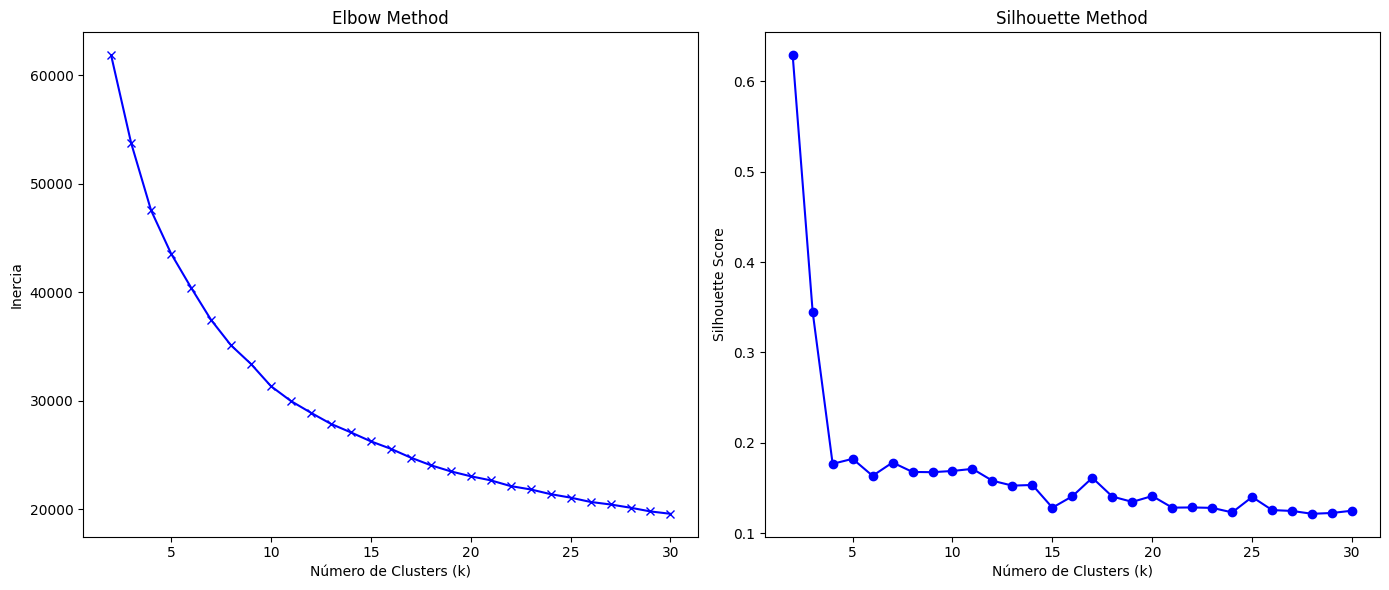

In [119]:
km_m.plot_elbow_silhouette(scaled_df, 30)

-   **Método del codo (Elbow Method)**: El gráfico de la izquierda muestra una caída rápida de la inercia (distorsión) al aumentar el número de clusters, pero luego se estabiliza de forma más gradual alrededor de **k = 4 o 5**. Esto sugiere que 4 o 5 clusters podrían ser una buena opción, ya que después de este punto, agregar más clusters no reduce significativamente la inercia.

-   **Método de la silueta (Silhouette Method)**: El gráfico de la derecha muestra que el puntaje de la silueta es más alto para **k = 2**, pero baja abruptamente al agregar más clusters. Sin embargo, para 4 clusters (o incluso 5), la silueta aún se mantiene en un valor aceptable antes de que disminuya más drásticamente. Esto respalda la idea de que 4 o 5 clusters son adecuados.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


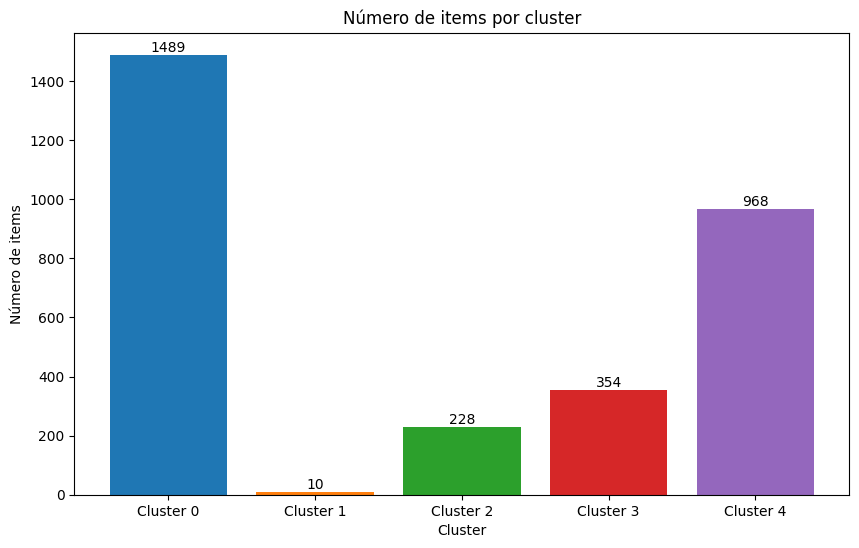

,COUNT(sales),MEAN(sales.event_Easter),MEAN(sales.event_NewYear),MEAN(sales.event_None),MEAN(sales.event_Ramadan starts),MEAN(sales.event_SuperBowl),MEAN(sales.event_Thanksgiving),MEAN(sales.raw_earn),MEAN(sales.sell_price),MEAN(sales.units),MEAN(sales.week),MEAN(sales.year),SUM(sales.event_Easter),SUM(sales.event_NewYear),SUM(sales.event_Ramadan starts),SUM(sales.event_SuperBowl),SUM(sales.event_Thanksgiving),SUM(sales.raw_earn),SUM(sales.sell_price),Cluster
item,,,,,,,,,,,,,,,,,,,,
ACCESORIES_1_001,1185,0.020253,0.018565,0.904641,0.016034,0.020253,0.020253,37.996321,11.017688,3.454008,27.129114,2014.459916,24.0,22.0,19.0,24.0,24.0,45025.64,13055.96,4
ACCESORIES_1_002,1899,0.017378,0.014745,0.909953,0.021590,0.017904,0.018431,14.061259,5.276540,2.664034,27.790416,2013.292786,33.0,28.0,41.0,34.0,35.0,26702.33,10020.15,0
ACCESORIES_1_003,665,0.028571,0.025564,0.896241,0.018045,0.021053,0.010526,8.499383,3.937880,2.157895,23.950376,2014.908271,19.0,17.0,12.0,14.0,7.0,5652.09,2618.69,3
ACCESORIES_1_004,2512,0.018312,0.018710,0.908838,0.015924,0.021099,0.017118,93.700155,5.985088,15.595143,25.860669,2013.216959,46.0,47.0,40.0,53.0,43.0,235374.79,15034.54,0
ACCESORIES_1_005,2134,0.018276,0.020150,0.902530,0.018276,0.021087,0.019681,26.082737,3.825309,6.851453,27.065136,2013.463449,39.0,43.0,39.0,45.0,42.0,55660.56,8163.21,0


In [120]:
# Apreciamos varias opciones 4 o 5
optimal_k = 5

kmeans_model, feature_matrix_with_clusters = km_m.apply_kmeans_and_plot(optimal_k, scaled_df, feature_matrix_renamed)

feature_matrix_with_clusters.head(5)

### Analisis

#### PCAs

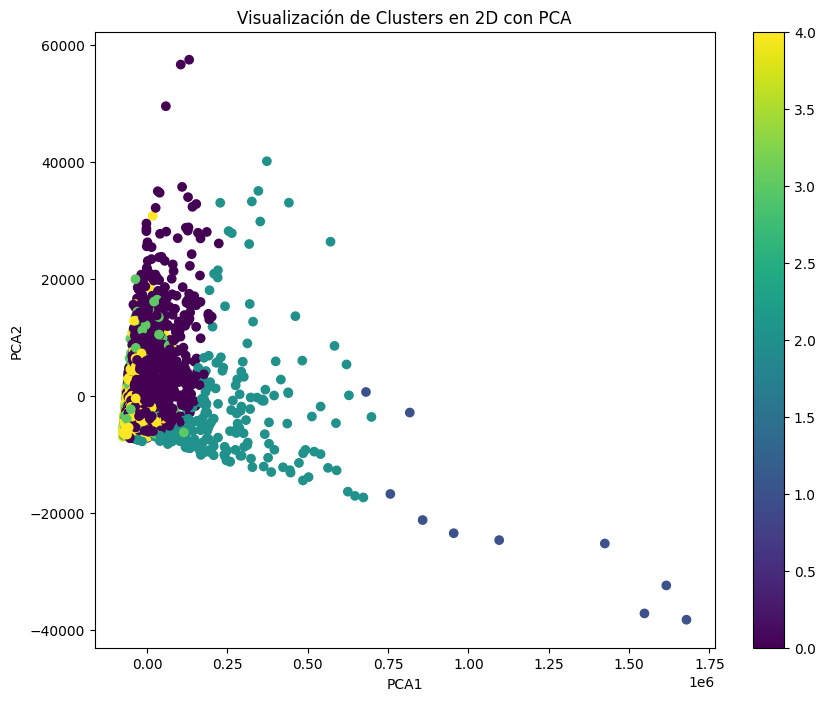

,PCA1,PCA2,Cluster
0,-30636.248445,4947.620382,4
1,-49017.061048,2305.382553,0
2,-70218.757935,-4676.961590,3
3,159715.346433,2994.687423,0
4,-20103.134232,-148.342536,0


In [121]:
pca_df = km_m.pca_visualization_2d(feature_matrix_with_clusters)

display(pca_df.head())

Principal Component 1: 1.00


array([0.99613507])

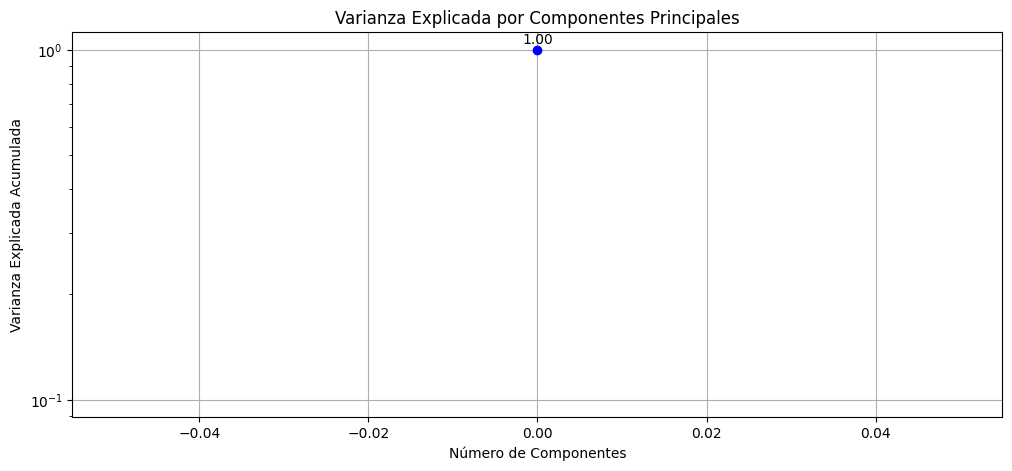

In [123]:
explained_variance = km_m.pca_variance_plot(feature_matrix_with_clusters, 1)

display(explained_variance)

#### Importancia caracteristicas

Cat cols: 0
Num cols: 19


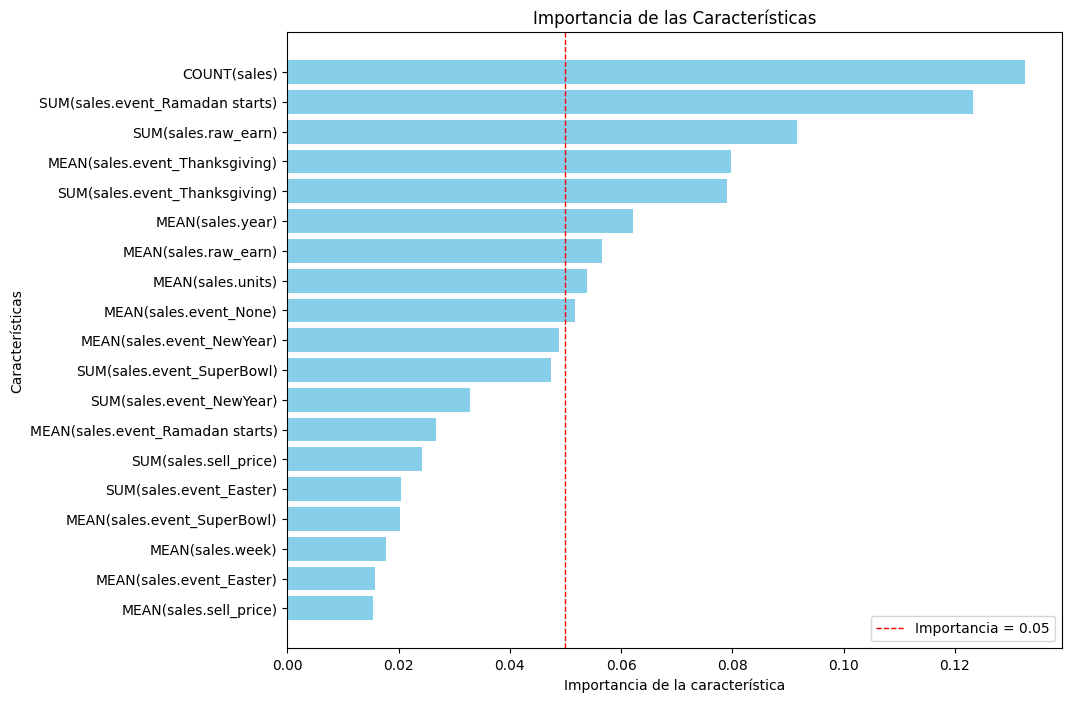

,Feature,Importance
0,COUNT(sales),0.132666
1,SUM(sales.event_Ramadan starts),0.123337
2,SUM(sales.raw_earn),0.091561
3,MEAN(sales.event_Thanksgiving),0.079697
4,SUM(sales.event_Thanksgiving),0.078984
5,MEAN(sales.year),0.062154
6,MEAN(sales.raw_earn),0.056577
7,MEAN(sales.units),0.053858
8,MEAN(sales.event_None),0.051781
9,MEAN(sales.event_NewYear),0.048764


In [124]:
# Preprocesamos datos
cluster_col='Cluster'
cols_to_scale = feature_matrix_with_clusters.columns.tolist()
df_clusters = feature_matrix_with_clusters[[cluster_col]].copy().reset_index(drop=True)
cols_to_scale.remove(cluster_col) # Columna Objetivo
preprocessed_df = pm.preprocess_features(feature_matrix_with_clusters[cols_to_scale])

# Combinar los DataFrames basándose en la columna 'Index'
preprocessed_df = pd.concat([preprocessed_df, df_clusters], axis=1)

clusters = kmeans_model.labels_

IMPORTANCE_THRES=0.05
prices_importance_df = km_m.get_feature_importances(preprocessed_df, clusters, imp_threshold=IMPORTANCE_THRES)

display(prices_importance_df.head(10))

### Dimension Redux

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


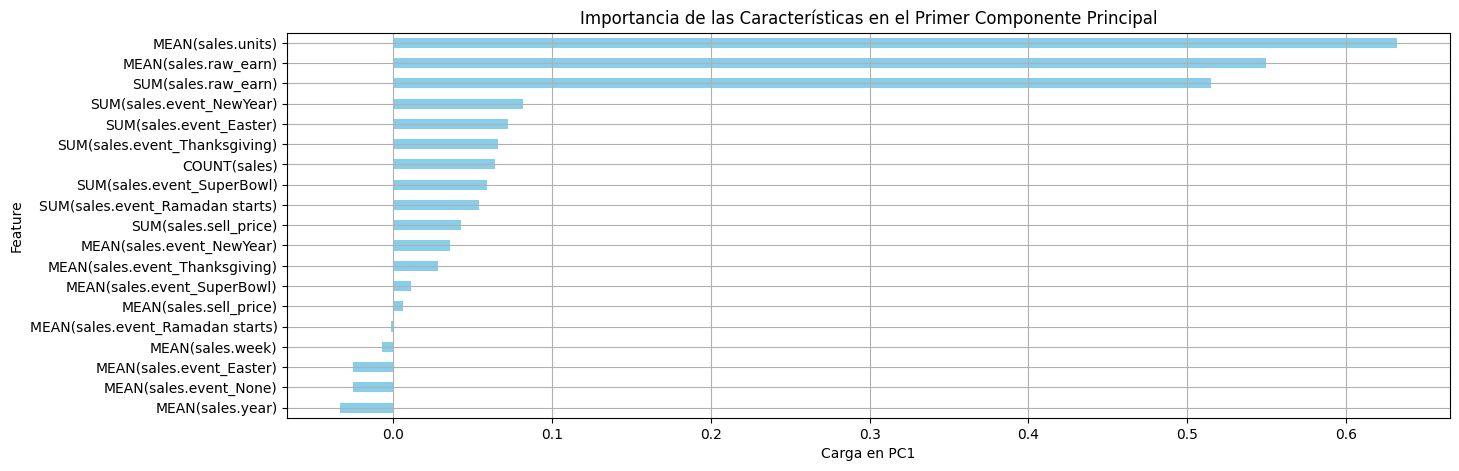

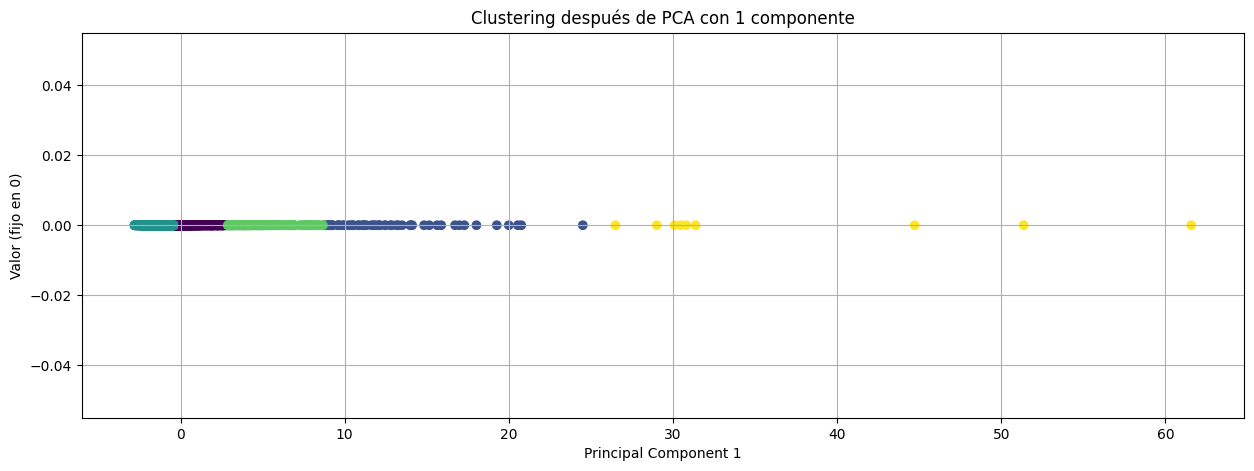

In [125]:
pca_df, importance_df = km_m.redux_dimensions_pca_and_cluster(preprocessed_df, n_clusters=optimal_k, n_components=1)

In [ ]:
# El segundo componente es residual
# pca_df, importance_df = km_m.redux_dimensions_pca_and_cluster(preprocessed_df, n_clusters=optimal_k, n_components=2)

## Descripcion de los clusters

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,COUNT(sales),MEAN(sales.event_Easter),MEAN(sales.event_NewYear),MEAN(sales.event_None),MEAN(sales.event_Ramadan starts),MEAN(sales.event_SuperBowl),MEAN(sales.event_Thanksgiving),MEAN(sales.raw_earn),MEAN(sales.sell_price),MEAN(sales.units),...,MEAN(sales.year),SUM(sales.event_Easter),SUM(sales.event_NewYear),SUM(sales.event_Ramadan starts),SUM(sales.event_SuperBowl),SUM(sales.event_Thanksgiving),SUM(sales.raw_earn),SUM(sales.sell_price),PC1,Cluster
0,-0.496040,0.118297,-0.118405,0.149200,-0.586754,-0.289933,0.581634,0.388096,1.499780,-0.299973,...,0.967864,-0.6250,-0.578947,-0.523810,-0.48,-0.30,0.026427,0.863530,-1.133740,2
1,0.210891,-0.572152,-0.752724,0.709012,1.006050,-0.878360,0.037087,-0.429012,0.240400,-0.399820,...,-0.182634,-0.0625,-0.263158,0.523810,-0.08,0.25,-0.269028,0.462539,-1.604810,2
2,-1.010891,2.115563,1.043470,-0.736248,-0.010192,-0.089666,-2.324805,-0.618886,-0.053249,-0.463792,...,1.409830,-0.9375,-0.842105,-0.857143,-0.88,-1.15,-0.608455,-0.515099,-2.419863,2
3,0.817822,-0.347764,-0.094367,0.591487,-0.618340,-0.078119,-0.355221,2.289743,0.395827,1.234579,...,-0.257381,0.7500,0.736842,0.476190,0.68,0.65,3.095729,1.124875,2.969832,3
4,0.443564,-0.356543,0.144659,-0.073290,0.055860,-0.081017,0.410772,-0.018616,-0.077942,0.129440,...,-0.014403,0.3125,0.526316,0.428571,0.36,0.60,0.197911,0.217261,-0.599601,2


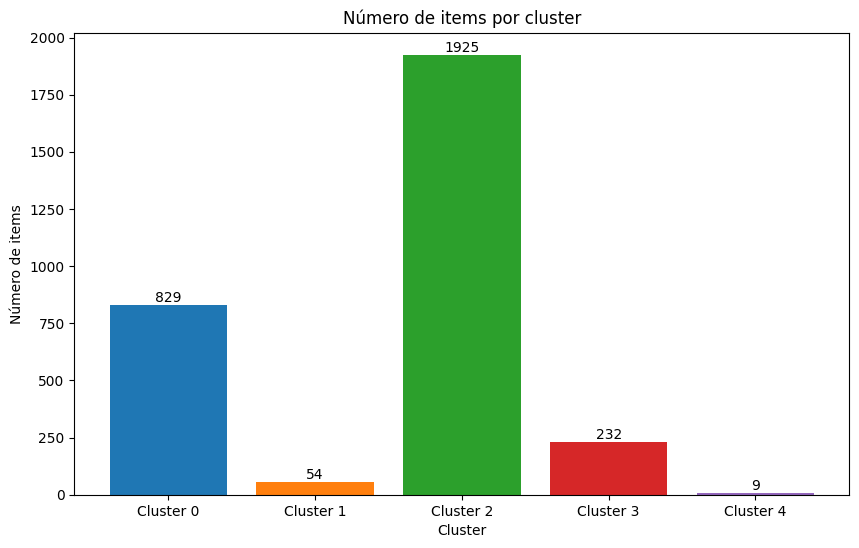

In [126]:
# Ejecutar PCA y clustering
optimal_k = 5
n_components = 1

df_with_pca, importance_df = km_m.pca_and_cluster(scaled_df, n_clusters=optimal_k, n_components=n_components)

# Mostrar el DataFrame con PCA y clustering
display(df_with_pca.head(5))

# Graficar la cantidad de items por cluster
# km_m.plot_items_per_cluster(df_with_pca)
show_clusters = km_m.plot_cluster_sizes(df_with_pca)

### Mostrar Descripcions

In [127]:
# Seleccionamos las features según su importancia en el componente principal
importance_df_filt = importance_df[importance_df['Loading_PC1'] >= 0.05]

importance_df_filt

# Crear y mostrar descripciones de los clusters
description_df = km_m.create_cluster_descriptions(df_with_pca, importance_df_filt)
print('###########################################################')
print('Descripcion de los clusters')
print('###########################################################')
display(description_df)

###########################################################
Descripcion de los clusters
###########################################################


,2,3,0,1,4
MEAN(sales.units),-0.130121,3.501995,0.972987,9.042789,24.309666
MEAN(sales.raw_earn),-0.190064,2.972605,0.854452,7.611081,22.852167
SUM(sales.raw_earn),-0.217793,3.094652,0.884960,7.057023,19.782128
SUM(sales.event_NewYear),-0.346822,0.564655,0.367469,0.524366,0.485380
SUM(sales.event_Easter),-0.333214,0.440463,0.304207,0.439815,0.458333
SUM(sales.event_Thanksgiving),-0.249117,0.479526,0.329976,0.469444,0.388889
COUNT(sales),-0.264069,0.448801,0.307184,0.422754,0.381848
SUM(sales.event_SuperBowl),-0.239522,0.403103,0.282461,0.377778,0.404444
SUM(sales.event_Ramadan starts),-0.218058,0.388957,0.274283,0.356261,0.285714


### Asignacion clusters a items

In [128]:
# Añadimos clusters a df_items
df_items = df_items.reset_index(drop=True) # Recuperamos indices originales

df_items_with_clusters = df_items.merge(df_with_pca[['Cluster']], left_index=True, right_index=True)

df_items_with_clusters.head()

,item,category,department,Cluster
0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,2
1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,2
2,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,2
3,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,3
4,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,2


In [129]:
# Crear dataframe con las descripciones de los clusters
cluster_summary = {
    0: {
        'cluster_name': 'Low Event Influence',
        'description': 'Productos con baja influencia de eventos en las ventas. Las métricas de ventas no se ven significativamente afectadas por eventos como el Año Nuevo, la Pascua o el Super Bowl.'
    },
    1: {
        'cluster_name': 'High Event Influence',
        'description': 'Productos con alta influencia de eventos en las ventas. Las ventas aumentan considerablemente durante eventos específicos como el Día de Acción de Gracias o el Año Nuevo, lo que sugiere que estos eventos tienen un gran impacto en las compras.'
    },
    2: {
        'cluster_name': 'Moderate Event Influence',
        'description': 'Productos con influencia moderada de eventos en las ventas. Los eventos tienen un efecto notable pero no tan pronunciado como en otros clusters. La respuesta a eventos como la Pascua o el Super Bowl es más equilibrada.'
    },
    3: {
        'cluster_name': 'Variable Event Influence',
        'description': 'Productos con influencia variable de eventos en las ventas. La respuesta a diferentes eventos es mixta, con algunas métricas mostrando incrementos en ventas durante eventos específicos, mientras que otras no se ven tan afectadas.'
    },
    4: {
        'cluster_name': 'Strong Event Influence',
        'description': 'Productos con una fuerte influencia de eventos en las ventas. Las métricas como ventas y ganancias muestran un aumento significativo durante eventos clave, indicando que estos productos se venden muy bien durante eventos como el Super Bowl o el Día de Acción de Gracias.'
    }
}

cluster_summary_df = pd.DataFrame.from_dict(cluster_summary, orient='index')

# Asumiendo que tienes un dataframe `items_df` que tiene una columna 'cluster' con los números de cluster
# Realiza un merge con el resumen de clusters para añadir los nombres y descripciones al dataframe original
items_with_cluster_info = df_items_with_clusters.merge(cluster_summary_df, left_on='Cluster', right_index=True, how='left')

# Resultado: `items_with_cluster_info` tendrá las columnas adicionales 'cluster_name' y 'description'
display(items_with_cluster_info.head())

,item,category,department,Cluster,cluster_name,description
0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,2,Moderate Event Influence,Productos con influencia moderada de eventos e...
1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,2,Moderate Event Influence,Productos con influencia moderada de eventos e...
2,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,2,Moderate Event Influence,Productos con influencia moderada de eventos e...
3,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,3,Variable Event Influence,Productos con influencia variable de eventos e...
4,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,2,Moderate Event Influence,Productos con influencia moderada de eventos e...


## Guardamos CSV

In [130]:
# Guardamos df como csv
from google.colab import files

file_name = 'items_clusters_events_influence_sales.csv'

# Exportar DataFrame a CSV (reemplaza 'df' por el nombre de tu DataFrame)
items_with_cluster_info.to_csv(file_name, index=False)

# Descargar el archivo CSV
files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

___
___

# SECCION - master

**Descripcion** Lipsum dolor sit amet

## Creacion caracteristicas

## Preprocesamiento

## Kmeans

## Descripcion de los clusters

___
___

# CLUSTERING MODULE

In [ ]:
from modules import clustering_module as cm

In [ ]:
# K-means
rf_model_kmeans, preprocessor_kmeans, pca_loadings_kmeans, pca_contributions_kmeans = cm.main(
    feature_matrix_renamed, method='kmeans', n_clusters=4
)

In [ ]:
# K-means
rf_model_kmeans, preprocessor_kmeans, pca_loadings_kmeans, pca_contributions_kmeans = cm.main(
    preprocessed_df, method='kmeans', n_clusters=optimal_k
)

In [ ]:
kmeans_cluster_labels, kmeans_cluster_summary = cm.perform_clustering_analysis(preprocessed_df, n_clusters=optimal_k)

In [ ]:
# display(kmeans_cluster_labels)

In [ ]:
display(kmeans_cluster_summary)

## !!! PENDING

___
___

# IDEAS

## PRODUCTOS

## TIENDAS

__A priori parece NO TENER sentido aplicar clustering a tiendas con tan pocas muestras.__

In [ ]:
# Creacion caracteristicas para tiendas basadas en el comportamiento temporal de ventas
fc_config = {
    'target_df':'shops',
    'agg_primitives':["sum", "mean", "std", "count"],
    'trans_primitives':[],
    'max_depth':2
}

feature_matrix, feature_defs = fcm.create_features(df_items, df_shops, df_ws, fc_config)

# Revision definiciones caracteristicas creadas
fcm.get_features_descriptions(feature_defs)

# Seleccionar y renombrar características relevantes para el clustering de productos ventas/performance
selected_features_sales = {
    'SUM(sales.units)': 'total_units_sold',
    'SUM(sales.raw_earn)': 'total_revenue',
    'MEAN(sales.units)': 'avg_units_per_week',
    'STD(sales.units)': 'std_units_sold',
    'COUNT(sales)': 'num_sales',
}

feature_matrix = fcm.select_features(feature_matrix, selected_features_sales)

# Remove low information, highly correlated, highly null and single value features
filtered_feature_matrix = fcm.filter_feature_matrix(feature_matrix)

display(filtered_feature_matrix.head(5))

# Renombrar características si es necesario
feature_matrix_renamed = fcm.rename_features(filtered_feature_matrix, selected_features)

display(feature_matrix_renamed.head(5))

# Preprocesamiento datos
scaled_df = pm.preprocess_features(feature_matrix_renamed)

In [ ]:
km_m.plot_elbow_silhouette(scaled_df, 9) # No puede haber mas clusters que etiquetas

In [ ]:
optimal_k = 6 # Segun elbow

kmeans_model, feature_matrix_with_clusters = km_m.apply_kmeans_and_plot(optimal_k, scaled_df, feature_matrix_renamed)

feature_matrix_with_clusters.head(5)

pca_df = km_m.pca_visualization_2d(feature_matrix_with_clusters)

display(pca_df.head())

km_m.pca_variance_plot(feature_matrix_with_clusters)

# Preprocesamos datos
cluster_col='Cluster'
cols_to_scale = feature_matrix_with_clusters.columns.tolist()
df_clusters = feature_matrix_with_clusters[[cluster_col]].copy().reset_index(drop=True)
cols_to_scale.remove(cluster_col) # Columna Objetivo
preprocessed_df = pm.preprocess_features(feature_matrix_with_clusters[cols_to_scale])

# Combinar los DataFrames basándose en la columna 'Index'
preprocessed_df = pd.concat([preprocessed_df, df_clusters], axis=1)

clusters = kmeans_model.labels_

# sales_importance_df = km_m.get_feature_importances(feature_matrix_with_clusters, clusters, imp_threshold=0.05)
sales_importance_df = km_m.get_feature_importances(preprocessed_df, clusters, imp_threshold=0.05)

display(sales_importance_df.head(10))

In [ ]:
display(scaled_df.head())

display(scaled_df.shape)

In [ ]:
km_m.plot_elbow_silhouette(scaled_df, 5) # No puede haber mas clusters que etiquetas

optimal_k = 5 # Segun silueta

kmeans_model, feature_matrix_with_clusters = km_m.apply_kmeans_and_plot(optimal_k, scaled_df, feature_matrix_renamed)

feature_matrix_with_clusters.head(5)

pca_df = km_m.pca_visualization_2d(feature_matrix_with_clusters)

display(pca_df.head())

km_m.pca_variance_plot(feature_matrix_with_clusters)

# Preprocesamos datos
cluster_col='Cluster'
cols_to_scale = feature_matrix_with_clusters.columns.tolist()
df_clusters = feature_matrix_with_clusters[[cluster_col]].copy().reset_index(drop=True)
cols_to_scale.remove(cluster_col) # Columna Objetivo
preprocessed_df = pm.preprocess_features(feature_matrix_with_clusters[cols_to_scale])

# Combinar los DataFrames basándose en la columna 'Index'
preprocessed_df = pd.concat([preprocessed_df, df_clusters], axis=1)

clusters = kmeans_model.labels_

# sales_importance_df = km_m.get_feature_importances(feature_matrix_with_clusters, clusters, imp_threshold=0.05)
sales_importance_df = km_m.get_feature_importances(preprocessed_df, clusters, imp_threshold=0.05)

display(sales_importance_df.head(10))

In [ ]:
# K-means
rf_model_kmeans, preprocessor_kmeans, pca_loadings_kmeans, pca_contributions_kmeans = cm.main(
    feature_matrix_renamed, method='kmeans', n_clusters=2
)

# Este error se da cuando el numero clusters es igual o mayor que el numero de etiquetas!!!